Importing all the required modules:
-

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno
#from ydata_profiling import ProfileReport
from sklearn import set_config
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN, KMeans
from sklearn.metrics import silhouette_score, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc
from pyclustering.cluster.clarans import clarans;
from pyclustering.utils import timedcall;
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, concatenate
import xgboost as xgb
from xgboost import XGBClassifier

Loading the Dataset:
-

In [3]:
telecom = pd.read_csv('telecom_customer_churn.csv')
telecom.head(3)

Customer ID  Gender  Age Married  Number of Dependents          City  \
0  0002-ORFBO  Female   37     Yes                     0  Frazier Park   
1  0003-MKNFE    Male   46      No                     0      Glendale   
2  0004-TLHLJ    Male   50      No                     0    Costa Mesa   

   Zip Code   Latitude   Longitude  Number of Referrals  ...   Payment Method  \
0     93225  34.827662 -118.999073                    2  ...      Credit Card   
1     91206  34.162515 -118.203869                    0  ...      Credit Card   
2     92627  33.645672 -117.922613                    0  ...  Bank Withdrawal   

  Monthly Charge Total Charges  Total Refunds Total Extra Data Charges  \
0           65.6        593.30           0.00                        0   
1           -4.0        542.40          38.33                       10   
2           73.9        280.85           0.00                        0   

  Total Long Distance Charges Total Revenue  Customer Status Churn Category  \
0                      381.51        974.81           Stayed            NaN   
1                       96.21        610.28           Stayed            NaN   
2                      134.60        415.45          Churned     Competitor   

                    Churn Reason  
0                            NaN  
1                            NaN  
2  Competitor had better devices  

[3 rows x 38 columns]

In [4]:
originalData = telecom
originalData.head()

Customer ID  Gender  Age Married  Number of Dependents          City  \
0  0002-ORFBO  Female   37     Yes                     0  Frazier Park   
1  0003-MKNFE    Male   46      No                     0      Glendale   
2  0004-TLHLJ    Male   50      No                     0    Costa Mesa   
3  0011-IGKFF    Male   78     Yes                     0      Martinez   
4  0013-EXCHZ  Female   75     Yes                     0     Camarillo   

   Zip Code   Latitude   Longitude  Number of Referrals  ...   Payment Method  \
0     93225  34.827662 -118.999073                    2  ...      Credit Card   
1     91206  34.162515 -118.203869                    0  ...      Credit Card   
2     92627  33.645672 -117.922613                    0  ...  Bank Withdrawal   
3     94553  38.014457 -122.115432                    1  ...  Bank Withdrawal   
4     93010  34.227846 -119.079903                    3  ...      Credit Card   

  Monthly Charge Total Charges  Total Refunds Total Extra Data Charges  \
0           65.6        593.30           0.00                        0   
1           -4.0        542.40          38.33                       10   
2           73.9        280.85           0.00                        0   
3           98.0       1237.85           0.00                        0   
4           83.9        267.40           0.00                        0   

  Total Long Distance Charges Total Revenue  Customer Status   Churn Category  \
0                      381.51        974.81           Stayed              NaN   
1                       96.21        610.28           Stayed              NaN   
2                      134.60        415.45          Churned       Competitor   
3                      361.66       1599.51          Churned  Dissatisfaction   
4                       22.14        289.54          Churned  Dissatisfaction   

                    Churn Reason  
0                            NaN  
1                            NaN  
2  Competitor had better devices  
3        Product dissatisfaction  
4            Network reliability  

[5 rows x 38 columns]

In [5]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 38 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Customer ID                        7043 non-null   object 
 1   Gender                             7043 non-null   object 
 2   Age                                7043 non-null   int64  
 3   Married                            7043 non-null   object 
 4   Number of Dependents               7043 non-null   int64  
 5   City                               7043 non-null   object 
 6   Zip Code                           7043 non-null   int64  
 7   Latitude                           7043 non-null   float64
 8   Longitude                          7043 non-null   float64
 9   Number of Referrals                7043 non-null   int64  
 10  Tenure in Months                   7043 non-null   int64  
 11  Offer                              7043 non-null   objec

Exploratory Data Analysis (EDA):
-

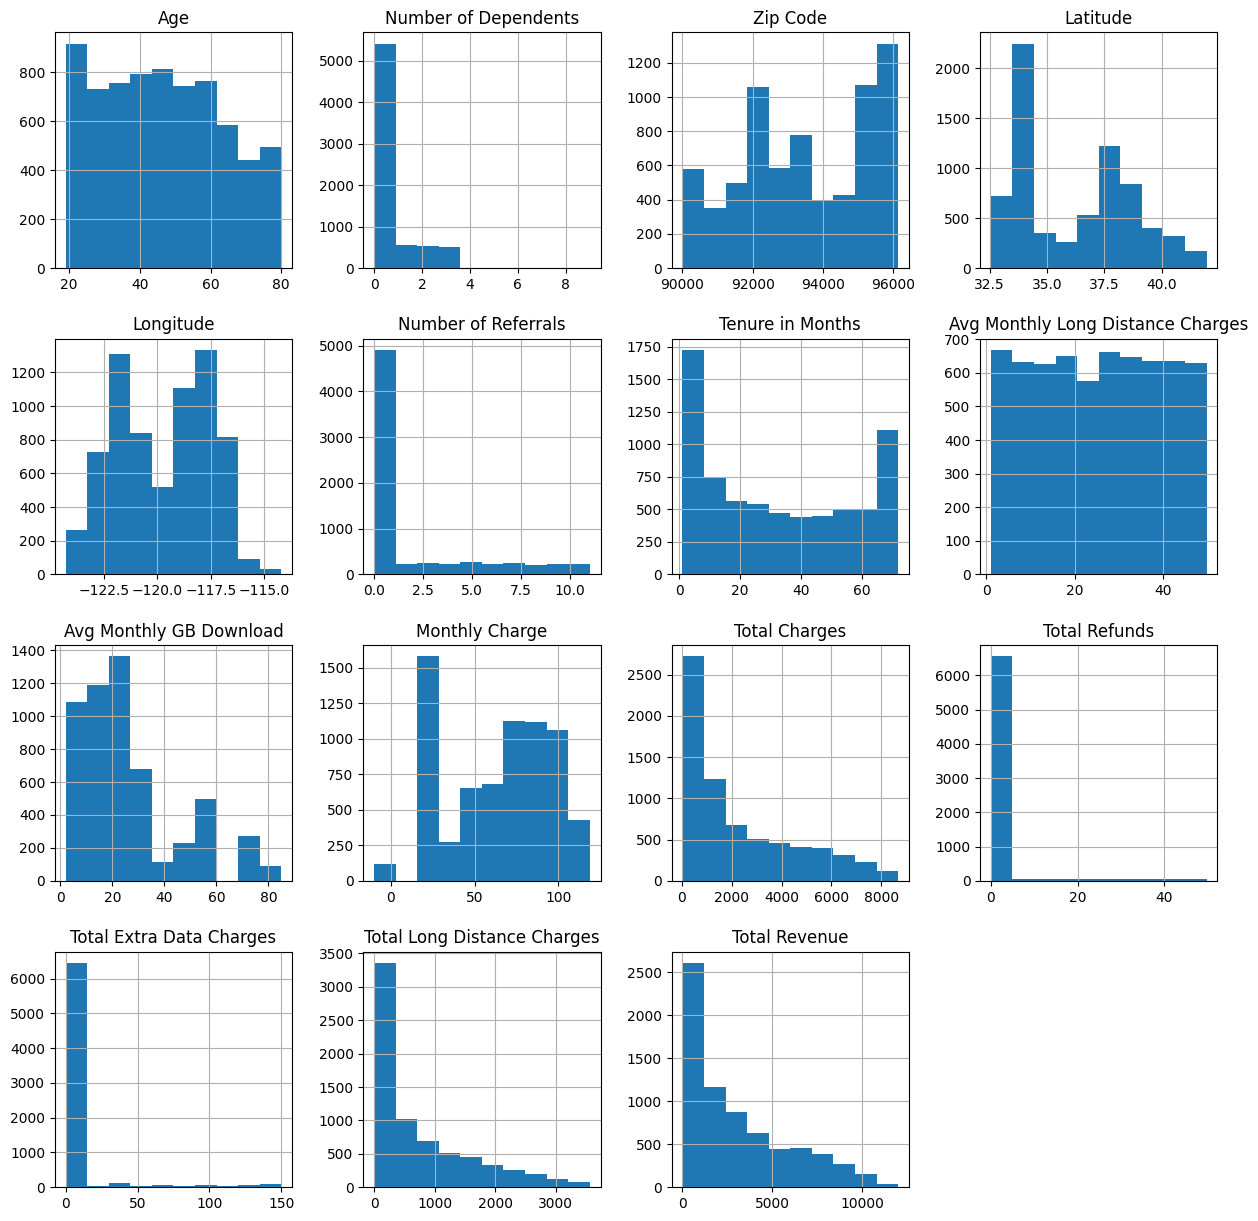

In [6]:
telecom.hist(figsize=(15,15), xrot=0);

In [7]:
telecom.describe()

Age  Number of Dependents      Zip Code     Latitude  \
count  7043.000000           7043.000000   7043.000000  7043.000000   
mean     46.509726              0.468692  93486.070567    36.197455   
std      16.750352              0.962802   1856.767505     2.468929   
min      19.000000              0.000000  90001.000000    32.555828   
25%      32.000000              0.000000  92101.000000    33.990646   
50%      46.000000              0.000000  93518.000000    36.205465   
75%      60.000000              0.000000  95329.000000    38.161321   
max      80.000000              9.000000  96150.000000    41.962127   

         Longitude  Number of Referrals  Tenure in Months  \
count  7043.000000          7043.000000       7043.000000   
mean   -119.756684             1.951867         32.386767   
std       2.154425             3.001199         24.542061   
min    -124.301372             0.000000          1.000000   
25%    -121.788090             0.000000          9.000000   
50%    -119.595293             0.000000         29.000000   
75%    -117.969795             3.000000         55.000000   
max    -114.192901            11.000000         72.000000   

       Avg Monthly Long Distance Charges  Avg Monthly GB Download  \
count                        6361.000000              5517.000000   
mean                           25.420517                26.189958   
std                            14.200374                19.586585   
min                             1.010000                 2.000000   
25%                            13.050000                13.000000   
50%                            25.690000                21.000000   
75%                            37.680000                30.000000   
max                            49.990000                85.000000   

       Monthly Charge  Total Charges  Total Refunds  Total Extra Data Charges  \
count     7043.000000    7043.000000    7043.000000               7043.000000   
mean        63.596131    2280.381264       1.962182                  6.860713   
std         31.204743    2266.220462       7.902614                 25.104978   
min        -10.000000      18.800000       0.000000                  0.000000   
25%         30.400000     400.150000       0.000000                  0.000000   
50%         70.050000    1394.550000       0.000000                  0.000000   
75%         89.750000    3786.600000       0.000000                  0.000000   
max        118.750000    8684.800000      49.790000                150.000000   

       Total Long Distance Charges  Total Revenue  
count                  7043.000000    7043.000000  
mean                    749.099262    3034.379056  
std                     846.660055    2865.204542  
min                       0.000000      21.360000  
25%                      70.545000     605.610000  
50%                     401.440000    2108.640000  
75%                    1191.100000    4801.145000  
max                    3564.720000   11979.340000

In [8]:
telecom.pivot_table(values='Monthly Charge', index='Contract', columns='Customer Status', aggfunc='mean')

Customer Status    Churned     Joined     Stayed
Contract                                        
Month-to-Month   71.784230  42.392279  62.284131
One Year         85.050904  35.622917  62.390404
Two Year         86.777083  57.695455  60.781081

In [9]:
telecom.pivot_table(values='Monthly Charge', index=['Contract', 'Multiple Lines'], columns='Customer Status', aggfunc='mean')

Customer Status                  Churned     Joined     Stayed
Contract       Multiple Lines                                 
Month-to-Month No              64.946474  41.740937  54.533750
               Yes             86.868837  59.691250  79.809915
One Year       No              77.111017  34.409091  50.719880
               Yes             95.886022  72.100000  80.950090
Two Year       No              67.695000  54.983333  44.332596
               Yes             95.341429  69.900000  75.144545

In [10]:
telecom.pivot_table(values='Monthly Charge', index=['Contract', 'Internet Service'], columns='Customer Status', aggfunc='mean')

Customer Status                    Churned     Joined     Stayed
Contract       Internet Service                                 
Month-to-Month No                19.356566  19.972531  20.314202
               Yes               75.119923  57.156504  70.645581
One Year       No                21.138889  18.543333  20.339766
               Yes               88.714650  64.088889  76.517436
Two Year       No                22.700000  21.100000  21.266851
               Yes               94.227907  68.458824  81.926715

In [11]:
telecom.pivot_table(values='Tenure in Months', index='Contract', columns='Customer Status', aggfunc='mean')

Customer Status    Churned    Joined     Stayed
Contract                                       
Month-to-Month   14.016918  1.705882  25.042663
One Year         44.963855  1.875000  41.494853
Two Year         61.270833  1.818182  54.353006

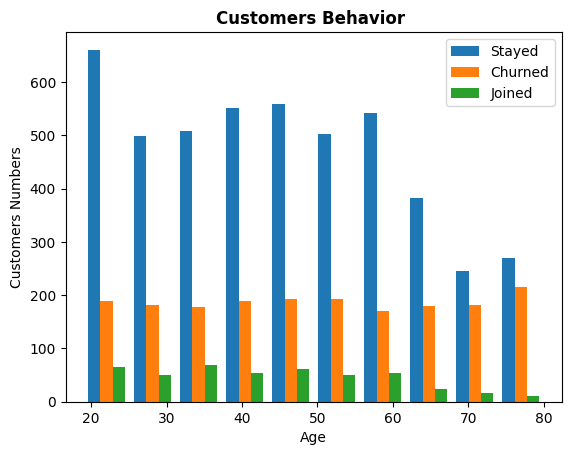

In [12]:
Customer_Stayed=telecom[telecom['Customer Status']=='Stayed'].Age
Customer_Churned=telecom[telecom['Customer Status']=='Churned'].Age
Customer_Joined=telecom[telecom['Customer Status']=='Joined'].Age

plt.xlabel('Age')
plt.ylabel('Customers Numbers')
plt.hist([Customer_Stayed,Customer_Churned,Customer_Joined],label=['Stayed','Churned','Joined'])

plt.title('Customers Behavior ',fontweight ="bold")
plt.legend();

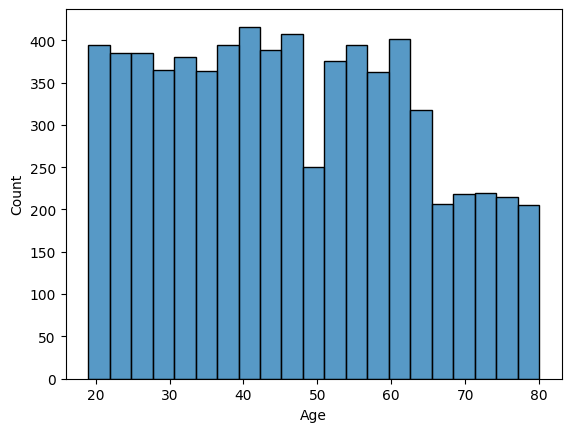

In [13]:
sns.histplot(telecom['Age']);

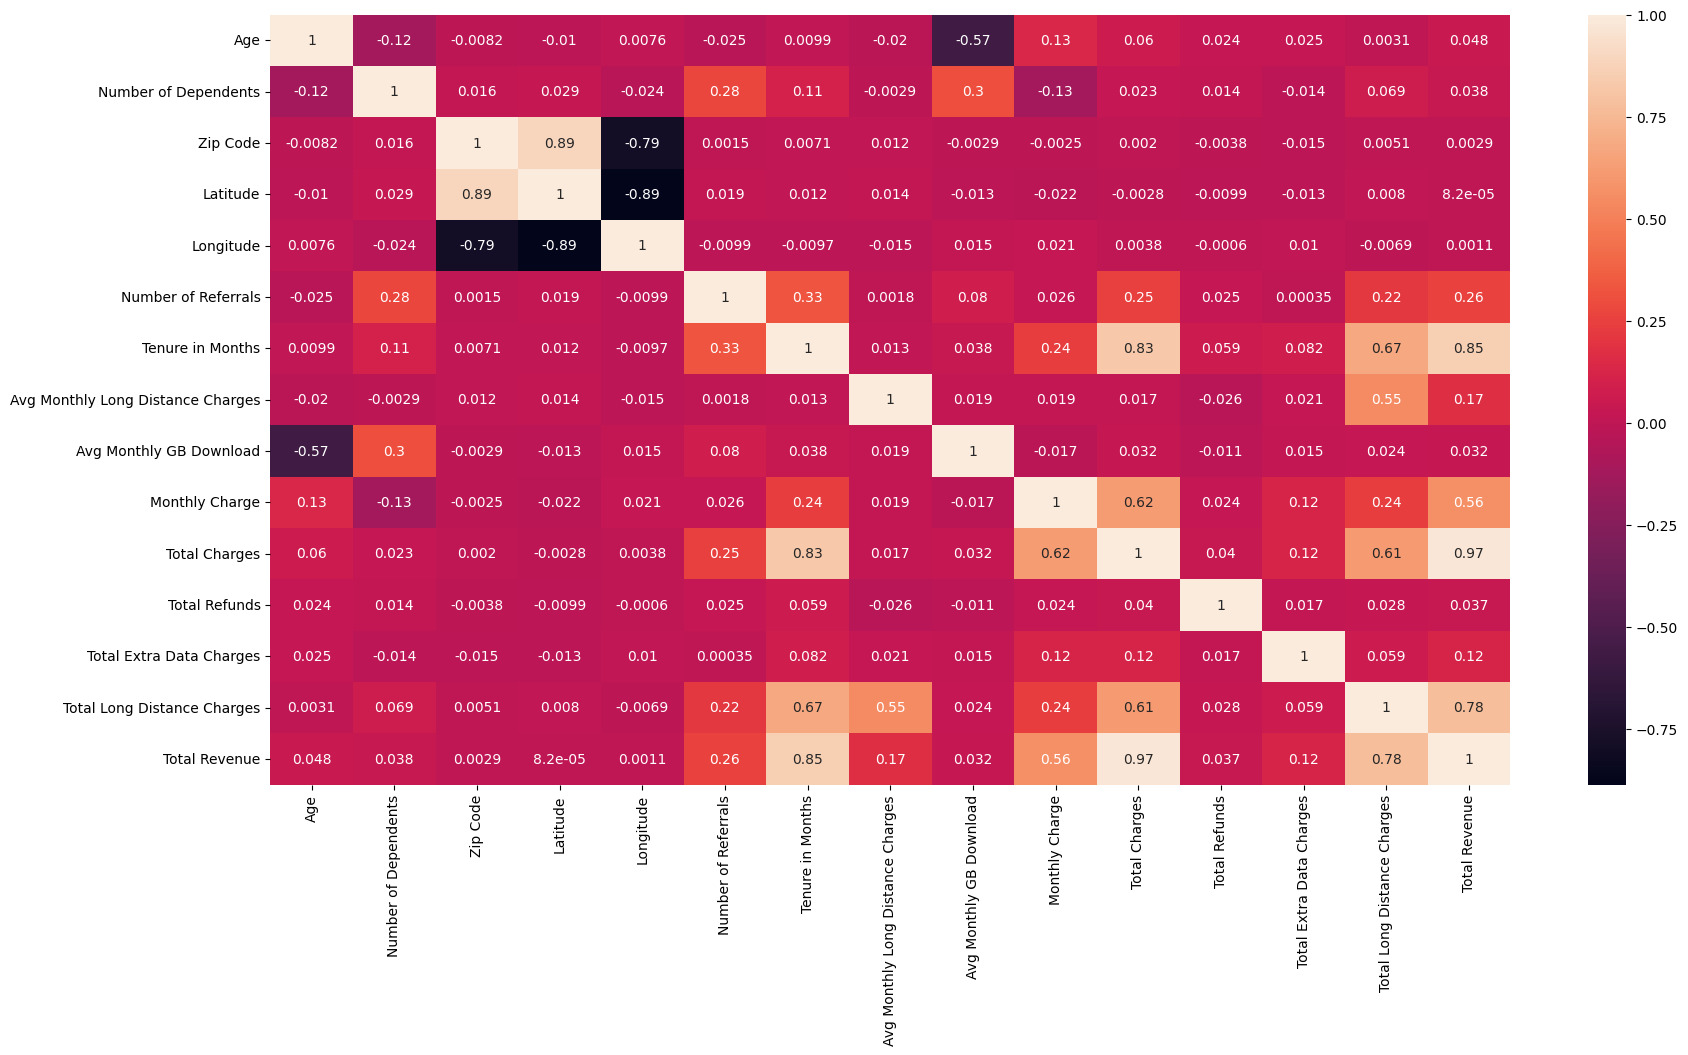

In [14]:
telecom_corr = telecom.select_dtypes(include='number')
corr_data  = telecom_corr.corr()
plt.figure(figsize = (20,10))
sns.heatmap(corr_data, annot = True);

In [15]:
fig = px.histogram(telecom, x="Customer Status", template ='xgridoff',barmode = "group", title = "<b>Customer Status Distribution<b>")
fig.update_layout(width=400, height=400, bargap=0.2)
fig.show()

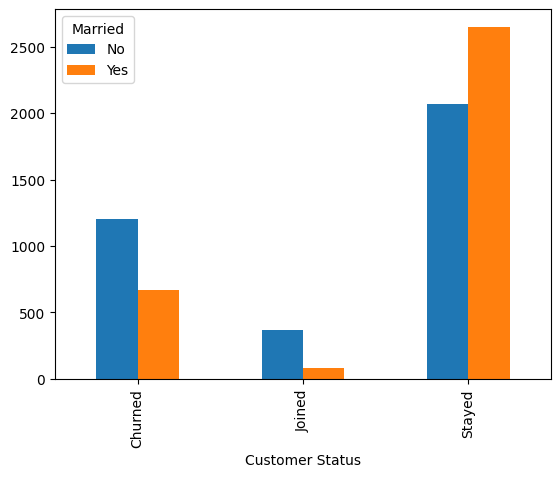

In [16]:
pd.crosstab(telecom['Customer Status'], telecom['Married']).plot(kind='bar');

<Axes: xlabel='Customer Status'>

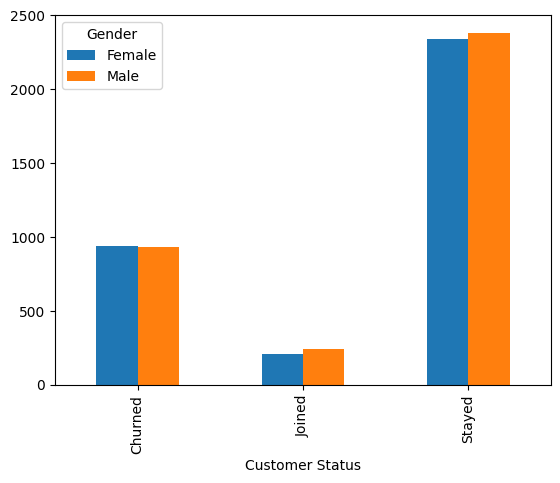

In [17]:
pd.crosstab(telecom['Customer Status'], telecom['Gender']).plot(kind='bar')

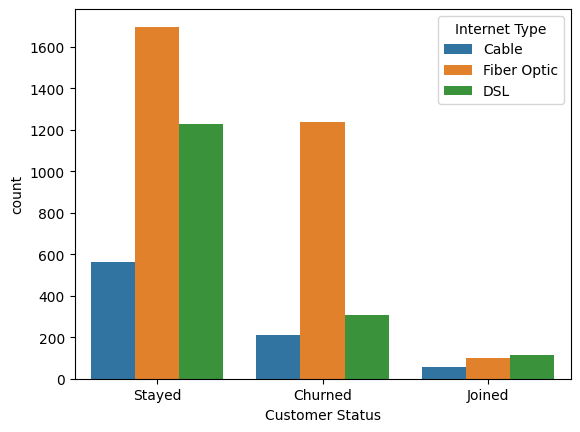

In [18]:
sns.countplot(data=telecom, x='Customer Status', hue='Internet Type');

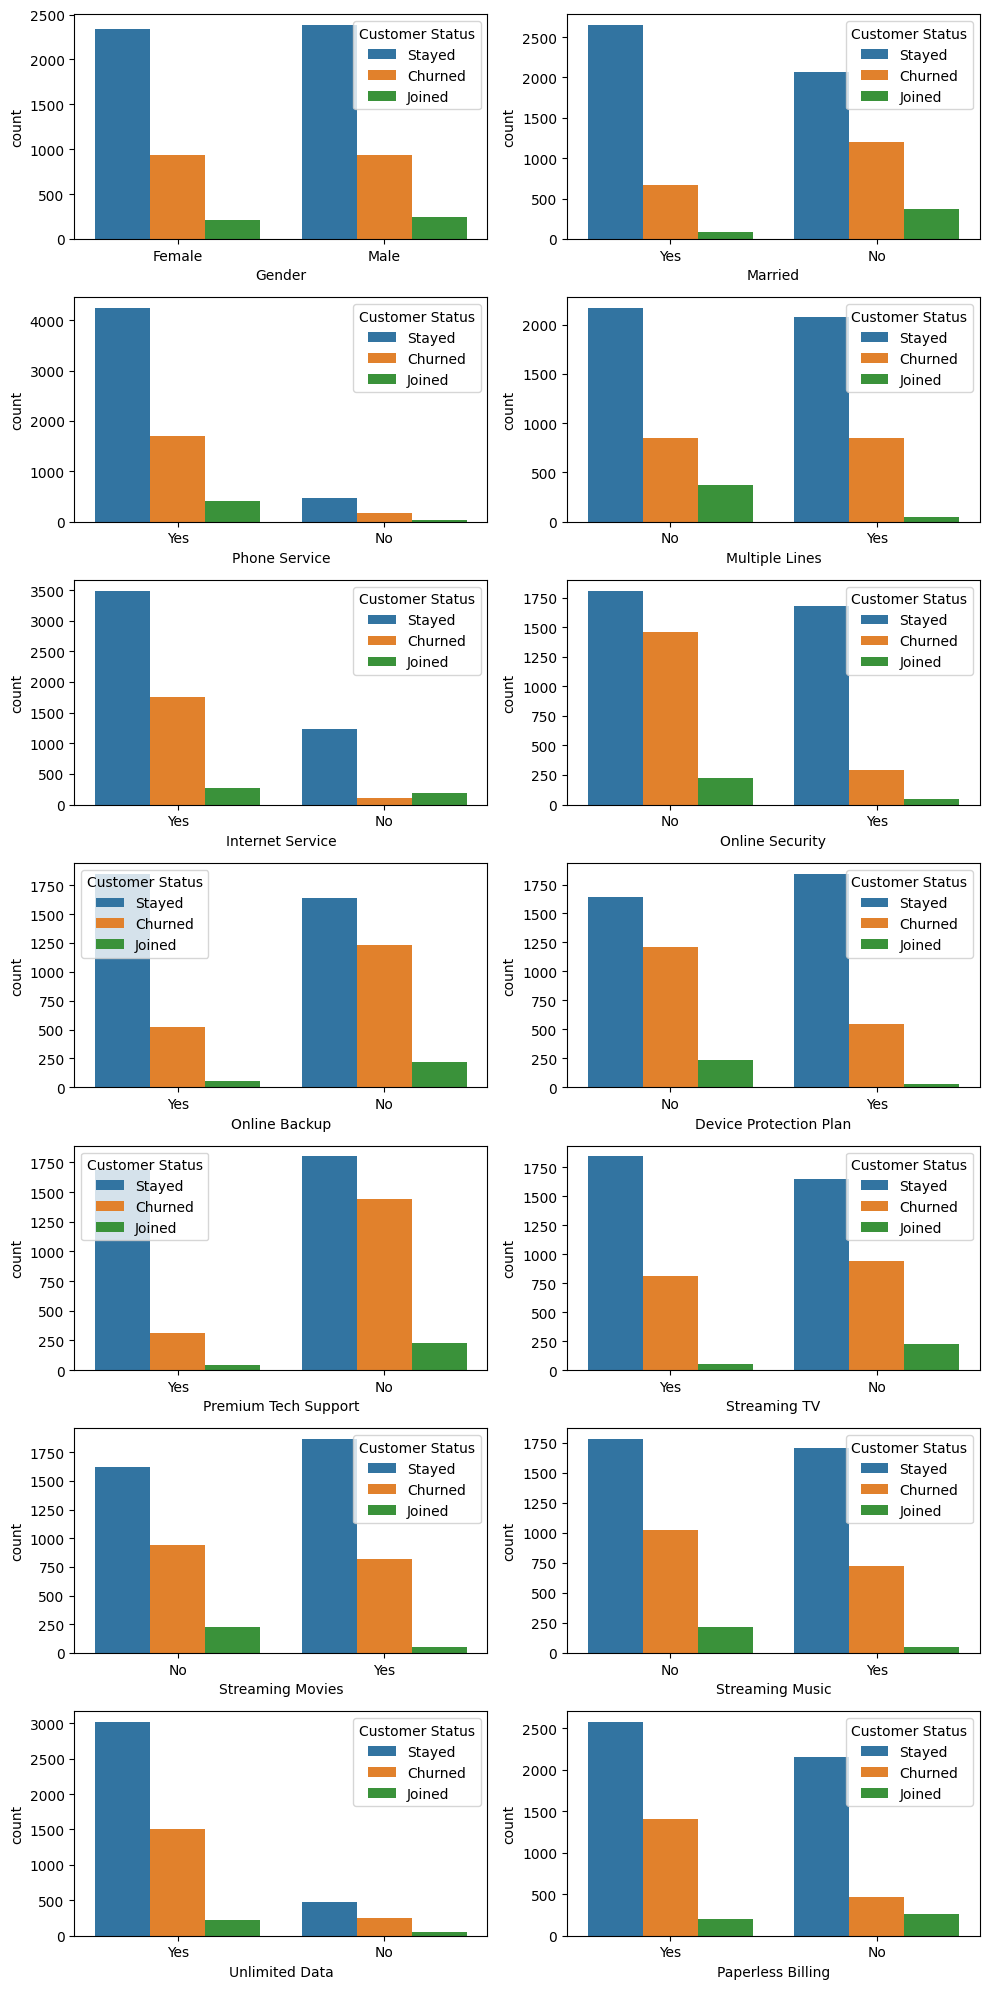

In [19]:
fig,axes=plt.subplots(7,2,figsize=(10,20))
sns.countplot(x="Gender",hue='Customer Status',data=telecom,ax=axes[0,0])
sns.countplot(x="Married",hue='Customer Status',data=telecom,ax=axes[0,1])
sns.countplot(x="Phone Service",hue='Customer Status',data=telecom,ax=axes[1,0])
sns.countplot(x="Multiple Lines",hue='Customer Status',data=telecom,ax=axes[1,1])
sns.countplot(x="Internet Service",hue='Customer Status',data=telecom,ax=axes[2,0])
sns.countplot(x="Online Security",hue='Customer Status',data=telecom,ax=axes[2,1])
sns.countplot(x="Online Backup",hue='Customer Status',data=telecom,ax=axes[3,0])
sns.countplot(x="Device Protection Plan",hue='Customer Status',data=telecom,ax=axes[3,1])
sns.countplot(x="Premium Tech Support",hue='Customer Status',data=telecom,ax=axes[4,0])
sns.countplot(x="Streaming TV",hue='Customer Status',data=telecom,ax=axes[4,1])
sns.countplot(x="Streaming Movies",hue='Customer Status',data=telecom,ax=axes[5,0])
sns.countplot(x="Streaming Music",hue='Customer Status',data=telecom,ax=axes[5,1])
sns.countplot(x="Unlimited Data",hue='Customer Status',data=telecom,ax=axes[6,0])
sns.countplot(x="Paperless Billing",hue='Customer Status',data=telecom,ax=axes[6,1])
plt.tight_layout()
plt.show()

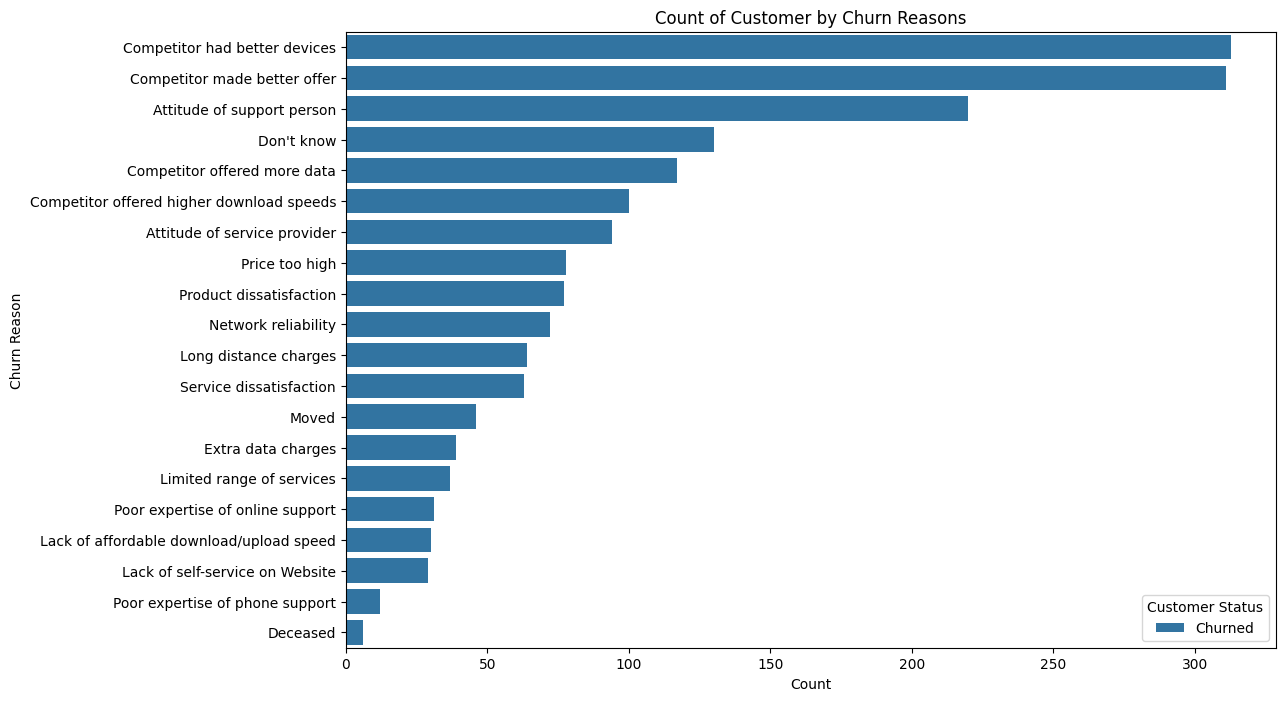

In [20]:
fig, ax = plt.subplots(figsize=(12, 8))
order = telecom[telecom['Customer Status'] == 'Churned']['Churn Reason'].value_counts().index
sns.countplot(data=telecom[telecom['Customer Status'] == 'Churned'], y='Churn Reason', hue='Customer Status', ax=ax, order=order)

plt.xlabel('Count')
plt.ylabel('Churn Reason')
plt.title('Count of Customer by Churn Reasons')

plt.show()

Data Cleaning:
-

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

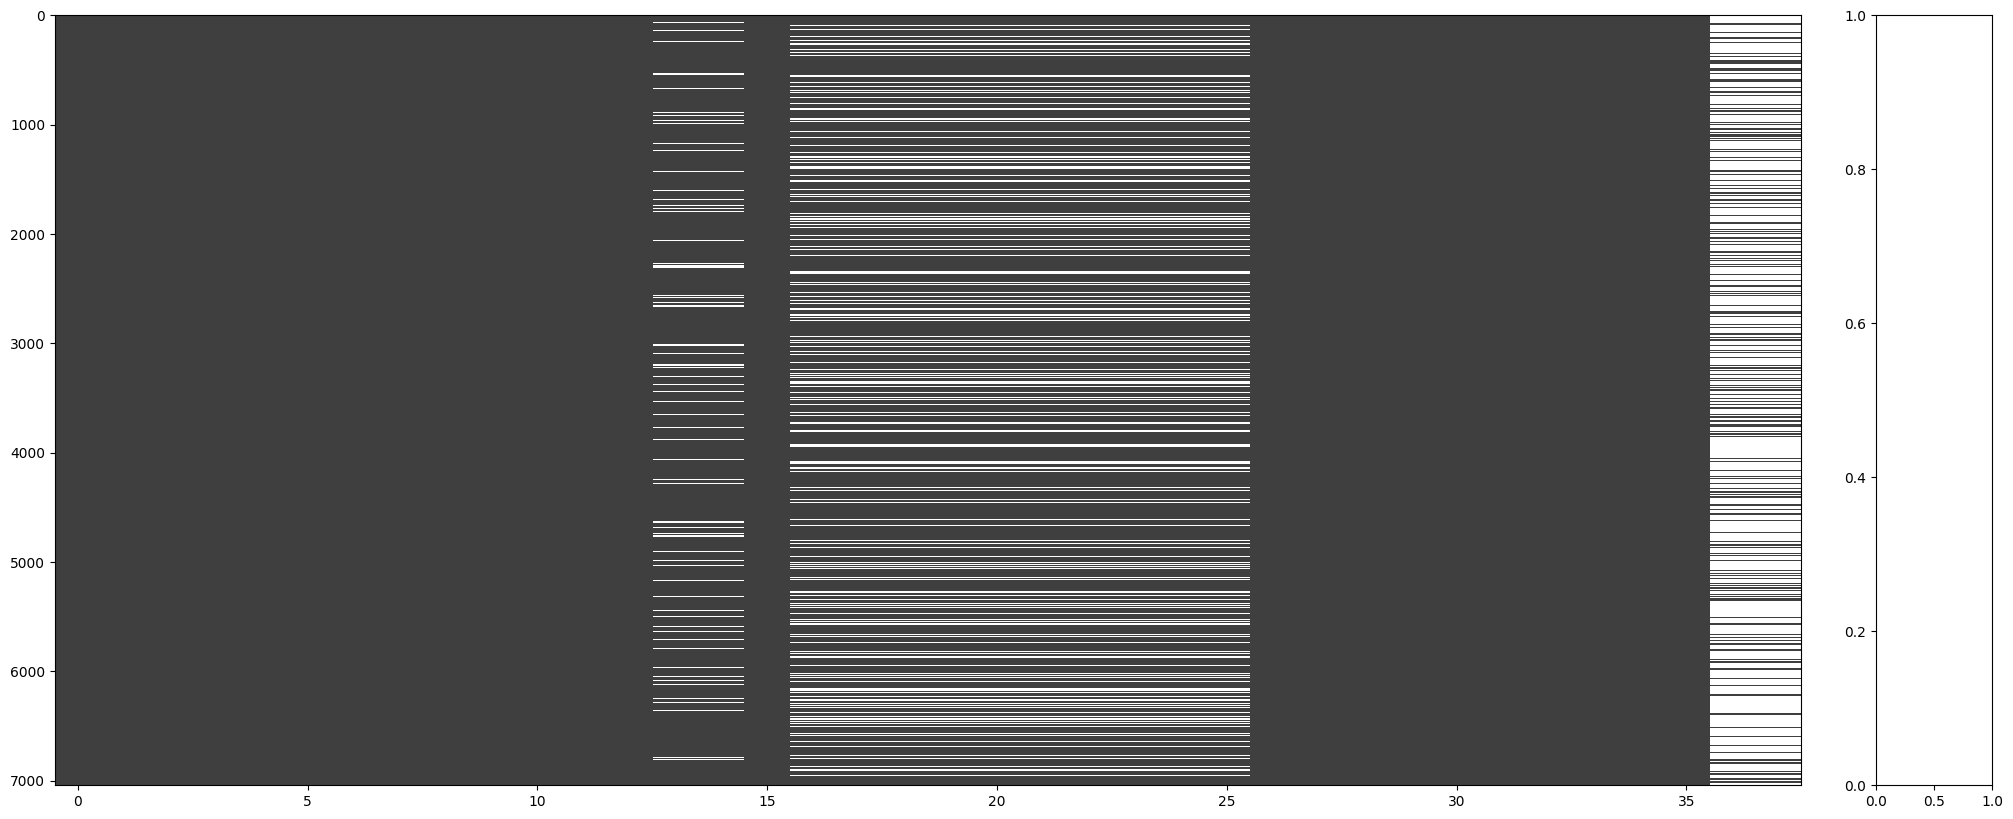

In [21]:
msno.matrix(telecom)

In [22]:
#Dropping the whole columns
telecom = telecom.drop('Churn Category',axis=1)
telecom = telecom.drop('Churn Reason',axis=1)
telecom = telecom.drop('Customer ID',axis=1)

In [23]:
#dropping the data values of "Joined" in the customer status
telecom = telecom.loc[telecom['Customer Status'] != 'Joined']

In [24]:
telecom.columns

Index(['Gender', 'Age', 'Married', 'Number of Dependents', 'City', 'Zip Code',
       'Latitude', 'Longitude', 'Number of Referrals', 'Tenure in Months',
       'Offer', 'Phone Service', 'Avg Monthly Long Distance Charges',
       'Multiple Lines', 'Internet Service', 'Internet Type',
       'Avg Monthly GB Download', 'Online Security', 'Online Backup',
       'Device Protection Plan', 'Premium Tech Support', 'Streaming TV',
       'Streaming Movies', 'Streaming Music', 'Unlimited Data', 'Contract',
       'Paperless Billing', 'Payment Method', 'Monthly Charge',
       'Total Charges', 'Total Refunds', 'Total Extra Data Charges',
       'Total Long Distance Charges', 'Total Revenue', 'Customer Status'],
      dtype='object')

In [25]:
a=telecom['Internet Service']
a.value_counts()

Internet Service
Yes    5245
No     1344
Name: count, dtype: int64

In [26]:
b=telecom['Internet Type']
b.value_counts()

Internet Type
Fiber Optic    2934
DSL            1537
Cable           774
Name: count, dtype: int64

Handling Null and Missing Values:

In [27]:
telecom['Internet Type'] = telecom['Internet Type'].fillna('No Internet')
telecom['Avg Monthly GB Download'] = telecom['Avg Monthly GB Download'].fillna(0)
telecom['Online Security'] = telecom['Online Security'].fillna('No Internet')
telecom['Online Backup'] = telecom['Online Backup'].fillna('No Internet')
telecom['Device Protection Plan'] = telecom['Device Protection Plan'].fillna('No Internet')
telecom['Premium Tech Support'] = telecom['Premium Tech Support'].fillna('No Internet')
telecom['Streaming TV'] = telecom['Streaming TV'].fillna('No Internet')
telecom['Streaming Movies'] = telecom['Streaming Movies'].fillna('No Internet')
telecom['Streaming Music'] = telecom['Streaming Music'].fillna('No Internet')
telecom['Unlimited Data'] = telecom['Unlimited Data'].fillna('No Internet')

In [28]:
telecom.isna().sum()

Gender                                 0
Age                                    0
Married                                0
Number of Dependents                   0
City                                   0
Zip Code                               0
Latitude                               0
Longitude                              0
Number of Referrals                    0
Tenure in Months                       0
Offer                                  0
Phone Service                          0
Avg Monthly Long Distance Charges    644
Multiple Lines                       644
Internet Service                       0
Internet Type                          0
Avg Monthly GB Download                0
Online Security                        0
Online Backup                          0
Device Protection Plan                 0
Premium Tech Support                   0
Streaming TV                           0
Streaming Movies                       0
Streaming Music                        0
Unlimited Data  

In [29]:
telecom['Phone Service'].value_counts()

Phone Service
Yes    5945
No      644
Name: count, dtype: int64

In [30]:
telecom['Multiple Lines'] = telecom['Multiple Lines'].fillna('No Phone Service')
telecom['Avg Monthly Long Distance Charges'] = telecom['Avg Monthly Long Distance Charges'].fillna(0)

Dropping Duplicates:

In [31]:
#Dropping the duplicate values (if any)
telecom = telecom.drop_duplicates()

ValueError: keyword grid_b is not recognized; valid keywords are ['size', 'width', 'color', 'tickdir', 'pad', 'labelsize', 'labelcolor', 'zorder', 'gridOn', 'tick1On', 'tick2On', 'label1On', 'label2On', 'length', 'direction', 'left', 'bottom', 'right', 'top', 'labelleft', 'labelbottom', 'labelright', 'labeltop', 'labelrotation', 'grid_agg_filter', 'grid_alpha', 'grid_animated', 'grid_antialiased', 'grid_clip_box', 'grid_clip_on', 'grid_clip_path', 'grid_color', 'grid_dash_capstyle', 'grid_dash_joinstyle', 'grid_dashes', 'grid_data', 'grid_drawstyle', 'grid_figure', 'grid_fillstyle', 'grid_gapcolor', 'grid_gid', 'grid_in_layout', 'grid_label', 'grid_linestyle', 'grid_linewidth', 'grid_marker', 'grid_markeredgecolor', 'grid_markeredgewidth', 'grid_markerfacecolor', 'grid_markerfacecoloralt', 'grid_markersize', 'grid_markevery', 'grid_mouseover', 'grid_path_effects', 'grid_picker', 'grid_pickradius', 'grid_rasterized', 'grid_sketch_params', 'grid_snap', 'grid_solid_capstyle', 'grid_solid_joinstyle', 'grid_transform', 'grid_url', 'grid_visible', 'grid_xdata', 'grid_ydata', 'grid_zorder', 'grid_aa', 'grid_c', 'grid_ds', 'grid_ls', 'grid_lw', 'grid_mec', 'grid_mew', 'grid_mfc', 'grid_mfcalt', 'grid_ms']

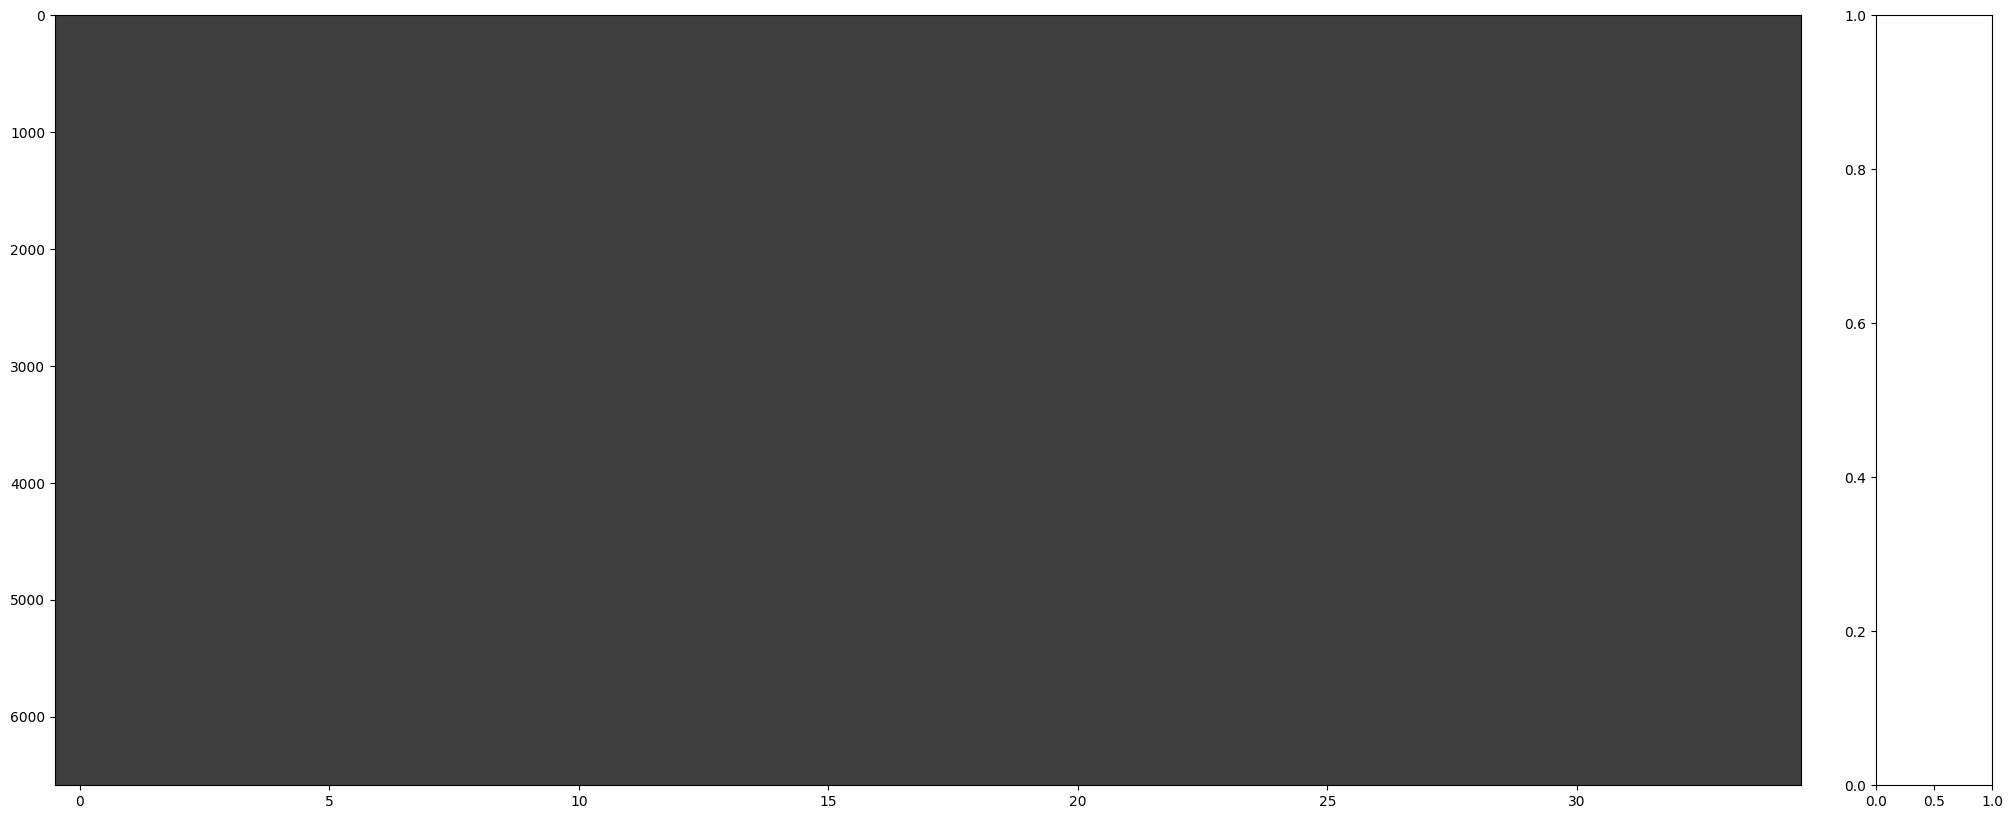

In [32]:
msno.matrix(telecom)

In [33]:
telecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6589 entries, 0 to 7042
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             6589 non-null   object 
 1   Age                                6589 non-null   int64  
 2   Married                            6589 non-null   object 
 3   Number of Dependents               6589 non-null   int64  
 4   City                               6589 non-null   object 
 5   Zip Code                           6589 non-null   int64  
 6   Latitude                           6589 non-null   float64
 7   Longitude                          6589 non-null   float64
 8   Number of Referrals                6589 non-null   int64  
 9   Tenure in Months                   6589 non-null   int64  
 10  Offer                              6589 non-null   object 
 11  Phone Service                      6589 non-null   object 
 1

In [ ]:
profile = ProfileReport(telecom)

Outlier Analysis:

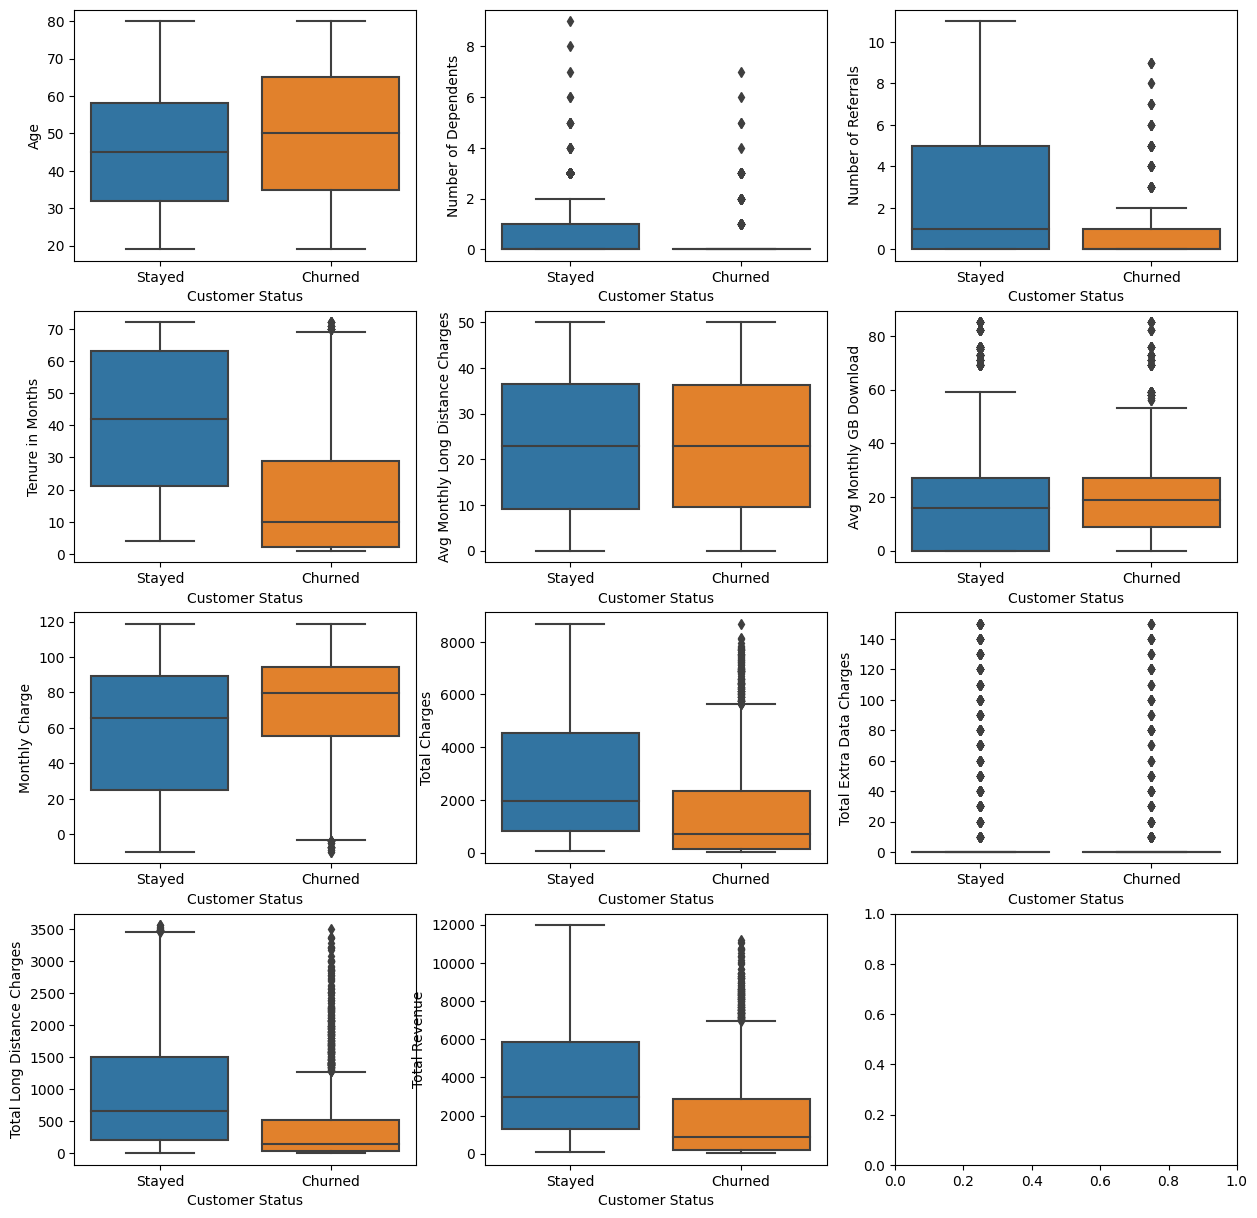

In [34]:
colnames=['Age','Number of Dependents','Number of Referrals','Tenure in Months','Avg Monthly Long Distance Charges',
                'Avg Monthly GB Download','Monthly Charge','Total Charges','Total Extra Data Charges','Total Long Distance Charges','Total Revenue']

fig, ax = plt.subplots(4,3, figsize = (15,15))
for i, subplot in zip(colnames, ax.flatten()):
    sns.boxplot(x = 'Customer Status', y = i , data = telecom, ax = subplot)

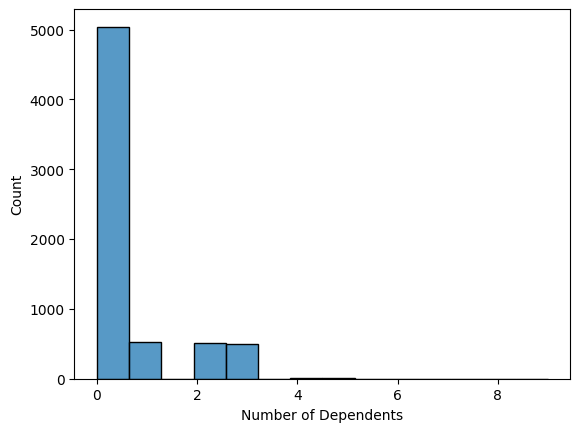

In [35]:
sns.histplot(telecom['Number of Dependents']);

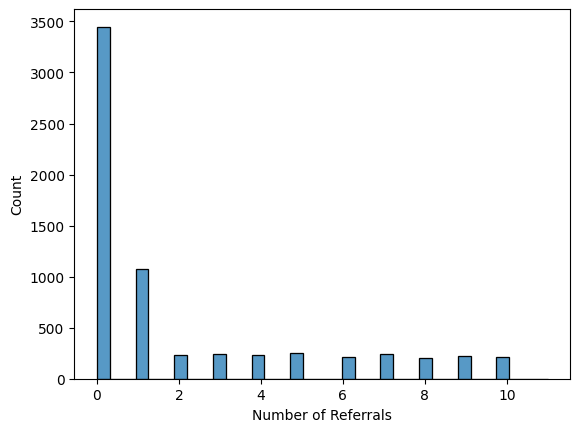

In [36]:
sns.histplot(telecom['Number of Referrals']);

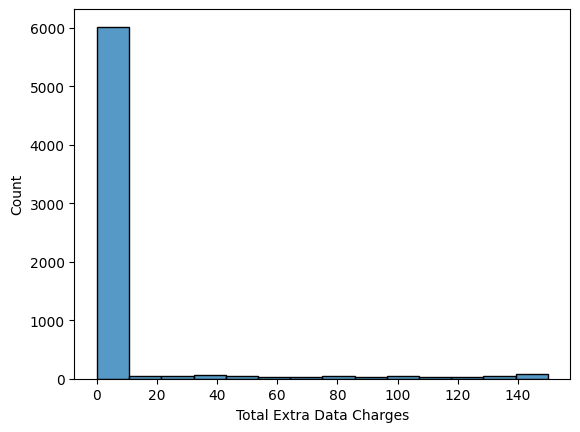

In [37]:
sns.histplot(telecom['Total Extra Data Charges']);

In [38]:
S=telecom['Total Extra Data Charges'].value_counts()
S.head()

Total Extra Data Charges
0     5905
10     113
40      61
30      52
20      48
Name: count, dtype: int64

Data Preprocessing and Transformation:

In [39]:
categorical_columns = ['Gender', 'City', 'Zip Code', 'Married', 'Offer', 'Phone Service', 'Multiple Lines', 'Internet Service',
                       'Internet Type', 'Online Security', 'Online Backup', 'Device Protection Plan',
                       'Premium Tech Support', 'Streaming TV', 'Streaming Movies', 'Streaming Music',
                       'Unlimited Data', 'Contract', 'Paperless Billing', 'Payment Method', 'Customer Status']

for column in categorical_columns:
    telecom[column] = pd.Categorical(telecom[column])

In [40]:
telecom.dtypes

Gender                               category
Age                                     int64
Married                              category
Number of Dependents                    int64
City                                 category
Zip Code                             category
Latitude                              float64
Longitude                             float64
Number of Referrals                     int64
Tenure in Months                        int64
Offer                                category
Phone Service                        category
Avg Monthly Long Distance Charges     float64
Multiple Lines                       category
Internet Service                     category
Internet Type                        category
Avg Monthly GB Download               float64
Online Security                      category
Online Backup                        category
Device Protection Plan               category
Premium Tech Support                 category
Streaming TV                      

In [41]:
data_telecom = telecom.copy()

In [42]:
df_X = telecom.drop('Customer Status', axis=1)
df_y = telecom['Customer Status']

In [43]:
set_config(display='diagram') # shows the pipeline graphically when printed

In [44]:
num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])
cat_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('cat_encoder', OneHotEncoder(sparse=False)) # returns a
        # regular matrix that can be combined easily with the data we get from
        # the numeric pipeline
    ])

SimpleImputer.get_feature_names_out = StandardScaler.get_feature_names_out  #

prep_pipeline = ColumnTransformer([
    ('num', num_pipeline, make_column_selector(dtype_include=np.number)),
    ('cat', cat_pipeline, make_column_selector(dtype_include='category'))
])

prep_pipeline

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('scaler', StandardScaler())]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x00000241471A7F10>),
                                ('cat',
                                 Pipeline(steps=[('imputer',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('cat_encoder',
                                                  OneHotEncoder(sparse=False))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x000002413F0B0F90>)])

In [45]:
processed_X = prep_pipeline.fit_transform(df_X, df_y)
df_processed_X = pd.DataFrame(processed_X,
                              columns = prep_pipeline.get_feature_names_out(),
                              index = df_X.index)
print(df_processed_X.shape)
df_processed_X.head()

(6589, 2799)


num__Age  num__Number of Dependents  num__Latitude  num__Longitude  \
0 -0.579600                  -0.491619      -0.554996        0.351930   
1 -0.045161                  -0.491619      -0.824038        0.720843   
2  0.192368                  -0.491619      -1.033094        0.851324   
3  1.855067                  -0.491619       0.734020       -1.093819   
4  1.676921                  -0.491619      -0.797613        0.314431   

   num__Number of Referrals  num__Tenure in Months  \
0                 -0.006926              -1.063957   
1                 -0.668349              -1.063957   
2                 -0.668349              -1.272578   
3                 -0.337638              -0.897060   
4                  0.323785              -1.314302   

   num__Avg Monthly Long Distance Charges  num__Avg Monthly GB Download  \
0                                1.253468                     -0.238987   
1                               -0.796233                     -0.533037   
2                                0.688345                      0.447129   
3                                0.311381                     -0.827087   
4                               -1.010255                     -0.484029   

   num__Monthly Charge  num__Total Charges  ...  \
0             0.018307           -0.811689  ...   
1            -2.219753           -0.834158  ...   
2             0.285202           -0.949616  ...   
3             1.060162           -0.527161  ...   
4             0.606762           -0.955553  ...   

   cat__Unlimited Data_No Internet  cat__Unlimited Data_Yes  \
0                              0.0                      1.0   
1                              0.0                      0.0   
2                              0.0                      1.0   
3                              0.0                      1.0   
4                              0.0                      1.0   

   cat__Contract_Month-to-Month  cat__Contract_One Year  \
0                           0.0                     1.0   
1                           1.0                     0.0   
2                           1.0                     0.0   
3                           1.0                     0.0   
4                           1.0                     0.0   

   cat__Contract_Two Year  cat__Paperless Billing_No  \
0                     0.0                        0.0   
1                     0.0                        1.0   
2                     0.0                        0.0   
3                     0.0                        0.0   
4                     0.0                        0.0   

   cat__Paperless Billing_Yes  cat__Payment Method_Bank Withdrawal  \
0                         1.0                                  0.0   
1                         0.0                                  0.0   
2                         1.0                                  1.0   
3                         1.0                                  1.0   
4                         1.0                                  0.0   

   cat__Payment Method_Credit Card  cat__Payment Method_Mailed Check  
0                              1.0                               0.0  
1                              1.0                               0.0  
2                              0.0                               0.0  
3                              0.0                               0.0  
4                              1.0                               0.0  

[5 rows x 2799 columns]

Feature Selection:
-

Univariate Feature Selection:

In [46]:
selector = SelectKBest(f_classif, k=50)
selector.fit_transform(df_processed_X, df_y)

cols = selector.get_support(indices=True)
features_df_new = df_processed_X.iloc[:,cols]

features_df_new.head()

num__Age  num__Number of Dependents  num__Number of Referrals  \
0 -0.579600                  -0.491619                 -0.006926   
1 -0.045161                  -0.491619                 -0.668349   
2  0.192368                  -0.491619                 -0.668349   
3  1.855067                  -0.491619                 -0.337638   
4  1.676921                  -0.491619                  0.323785   

   num__Tenure in Months  num__Monthly Charge  num__Total Charges  \
0              -1.063957             0.018307           -0.811689   
1              -1.063957            -2.219753           -0.834158   
2              -1.272578             0.285202           -0.949616   
3              -0.897060             1.060162           -0.527161   
4              -1.314302             0.606762           -0.955553   

   num__Total Long Distance Charges  num__Total Revenue  cat__Married_No  \
0                         -0.487965           -0.791908              0.0   
1                         -0.822156           -0.919617              1.0   
2                         -0.777187           -0.987873              1.0   
3                         -0.511217           -0.573051              0.0   
4                         -0.908919           -1.031984              0.0   

   cat__Married_Yes  ...  cat__Streaming Music_No Internet  \
0               1.0  ...                               0.0   
1               0.0  ...                               0.0   
2               0.0  ...                               0.0   
3               1.0  ...                               0.0   
4               1.0  ...                               0.0   

   cat__Unlimited Data_No Internet  cat__Unlimited Data_Yes  \
0                              0.0                      1.0   
1                              0.0                      0.0   
2                              0.0                      1.0   
3                              0.0                      1.0   
4                              0.0                      1.0   

   cat__Contract_Month-to-Month  cat__Contract_One Year  \
0                           0.0                     1.0   
1                           1.0                     0.0   
2                           1.0                     0.0   
3                           1.0                     0.0   
4                           1.0                     0.0   

   cat__Contract_Two Year  cat__Paperless Billing_No  \
0                     0.0                        0.0   
1                     0.0                        1.0   
2                     0.0                        0.0   
3                     0.0                        0.0   
4                     0.0                        0.0   

   cat__Paperless Billing_Yes  cat__Payment Method_Bank Withdrawal  \
0                         1.0                                  0.0   
1                         0.0                                  0.0   
2                         1.0                                  1.0   
3                         1.0                                  1.0   
4                         1.0                                  0.0   

   cat__Payment Method_Credit Card  
0                              1.0  
1                              1.0  
2                              0.0  
3                              0.0  
4                              1.0  

[5 rows x 50 columns]

Principal Component Analysis:

In [47]:
pca = PCA(n_components=30)
pca_features = pca.fit_transform(features_df_new, df_y)
new_df = pca.transform(features_df_new)

Recurrent Feature Elimination:

In [48]:
random_forest = RandomForestClassifier()

rfe = RFE(random_forest, n_features_to_select=20)

rfe.fit(pca_features, df_y)

selected_features = rfe.support_

cols1 = rfe.get_support(indices=True)
df_3 = features_df_new.iloc[:,cols1]
df_3.columns

Index(['num__Age', 'num__Number of Dependents', 'num__Number of Referrals',
       'num__Tenure in Months', 'num__Monthly Charge', 'num__Total Charges',
       'cat__Married_Yes', 'cat__Zip Code_92122', 'cat__Offer_Offer A',
       'cat__Offer_Offer B', 'cat__Offer_Offer E', 'cat__Internet Service_Yes',
       'cat__Internet Type_DSL', 'cat__Internet Type_No Internet',
       'cat__Online Security_No', 'cat__Online Security_No Internet',
       'cat__Online Security_Yes', 'cat__Online Backup_No Internet',
       'cat__Online Backup_Yes', 'cat__Device Protection Plan_No'],
      dtype='object')

In [49]:
print(df_3.head())

   num__Age  num__Number of Dependents  num__Number of Referrals  \
0 -0.579600                  -0.491619                 -0.006926   
1 -0.045161                  -0.491619                 -0.668349   
2  0.192368                  -0.491619                 -0.668349   
3  1.855067                  -0.491619                 -0.337638   
4  1.676921                  -0.491619                  0.323785   

   num__Tenure in Months  num__Monthly Charge  num__Total Charges  \
0              -1.063957             0.018307           -0.811689   
1              -1.063957            -2.219753           -0.834158   
2              -1.272578             0.285202           -0.949616   
3              -0.897060             1.060162           -0.527161   
4              -1.314302             0.606762           -0.955553   

   cat__Married_Yes  cat__Zip Code_92122  cat__Offer_Offer A  \
0               1.0                  0.0                 0.0   
1               0.0                  0.0        

In [50]:
data = df_3.values

Clustering:
-

DBSCAN Clustering:

In [51]:
# Perform DBSCAN clustering
dbscan = DBSCAN(eps=1, min_samples=3)
dbscan_labels = dbscan.fit_predict(data)

# Get the number of unique labels
num_unique_labels = len(np.unique(dbscan_labels))

if num_unique_labels > 1:
    # Calculate silhouette score only if there are multiple labels
    dbscan_score = silhouette_score(data, dbscan_labels)
    print("DBSCAN Silhouette Score:", dbscan_score)
else:
    print("DBSCAN: Only one label found. Unable to calculate silhouette score.")

DBSCAN Silhouette Score: -0.14134191647931937


KMeans Clustering:

In [52]:
# Perform KMeans clustering
kmeans = KMeans(n_clusters=3, random_state=24, n_init=10)
kmeans_labels = kmeans.fit_predict(data)

# Calculate silhouette score for KMeans clustering
kmeans_score = silhouette_score(data, kmeans_labels)
print("KMeans Silhouette Score:", kmeans_score)

KMeans Silhouette Score: 0.24763374148651673


CLARANS Clustering:

In [53]:
num_clusters = 5
num_local = 3
max_neighborhoods = 2

In [54]:
# Initializing CLARANS clustering object
clarans_instance = clarans(data.tolist(), num_clusters, num_local, max_neighborhoods)

In [55]:
# Perform CLARANS clustering
(ticks, result) = timedcall(clarans_instance.process);
print("Execution time : ", ticks, "\n");

Execution time :  1693.922286099987 



In [56]:
#Get the cluster labels
clst = clarans_instance.get_clusters();

In [57]:
#Get the best mediods of the clusters 
med = clarans_instance.get_medoids();

In [58]:
print("Index of clusters' points :\n",clst)
print("\nLabel class of each point :\n ",df_y)
print("\nIndex of the best medoids : ",med)

Index of clusters' points :
 [[2, 8, 22, 52, 60, 84, 89, 123, 134, 148, 156, 162, 170, 188, 203, 228, 230, 246, 257, 263, 271, 322, 362, 389, 391, 397, 410, 416, 441, 445, 453, 484, 488, 489, 493, 509, 517, 521, 526, 537, 552, 561, 574, 598, 599, 627, 645, 649, 654, 661, 690, 693, 695, 697, 748, 776, 782, 785, 796, 797, 806, 817, 847, 857, 866, 887, 888, 903, 905, 906, 945, 946, 958, 965, 975, 986, 995, 1023, 1028, 1038, 1043, 1045, 1046, 1076, 1108, 1146, 1158, 1164, 1213, 1226, 1241, 1248, 1260, 1267, 1269, 1280, 1306, 1311, 1316, 1328, 1358, 1362, 1409, 1455, 1469, 1515, 1531, 1532, 1546, 1572, 1597, 1602, 1604, 1617, 1640, 1650, 1659, 1670, 1676, 1689, 1710, 1713, 1717, 1745, 1749, 1751, 1761, 1770, 1789, 1794, 1817, 1822, 1828, 1831, 1839, 1849, 1855, 1892, 1919, 1967, 1972, 1975, 1984, 1985, 1999, 2004, 2014, 2039, 2044, 2110, 2119, 2132, 2172, 2193, 2221, 2222, 2235, 2242, 2282, 2299, 2309, 2336, 2385, 2387, 2389, 2396, 2419, 2421, 2447, 2452, 2463, 2486, 2492, 2501, 2551, 2562,

Clustering Visualizations:

_DBSCAN Clustering:_

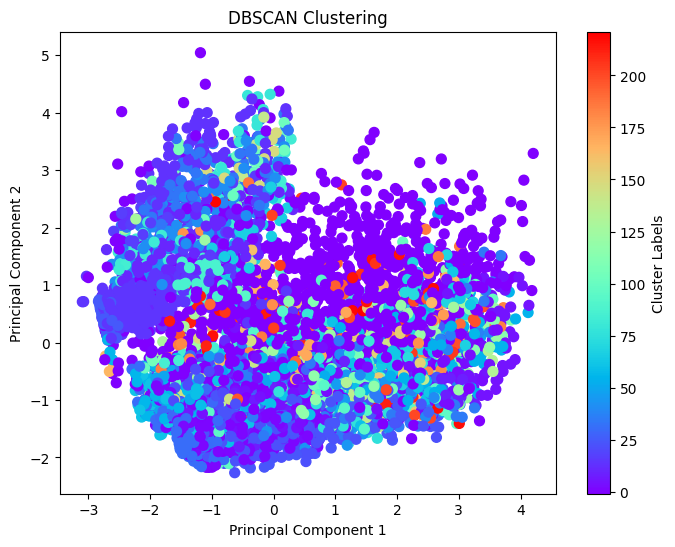

In [59]:
# Applying PCA for dimensionality reduction
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

# Creating a scatter plot for DBSCAN clustering results
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=dbscan_labels, cmap='rainbow', s=50)
plt.title("DBSCAN Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster Labels")
plt.show()

_KMeans Clustering:_

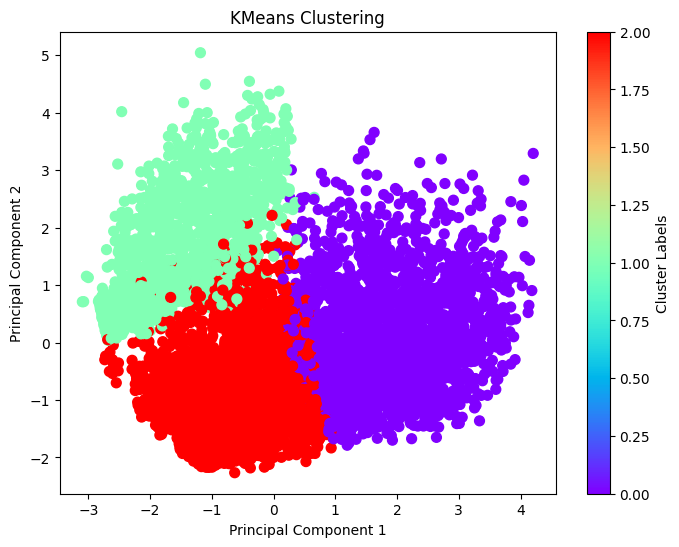

In [60]:
# Applying PCA for dimensionality reduction
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data)

# Creating a scatter plot for KMeans clustering results
plt.figure(figsize=(8, 6))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c=kmeans_labels, cmap='rainbow', s=50)
plt.title("KMeans Clustering")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.colorbar(label="Cluster Labels")
plt.show()

_CLARNS Clustering:_

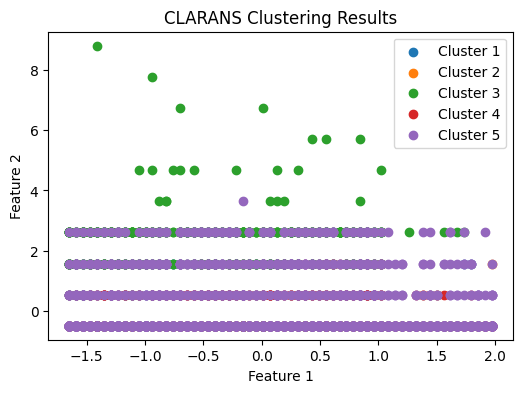

In [61]:
# Retrieving the CLARANS cluster assignments
clarans_clusters = clarans_instance.get_clusters()

# Creating a scatter plot for visualizing the clusters
plt.figure(figsize=(6, 4))

for cluster_idx, cluster in enumerate(clarans_clusters):
    cluster_points = data[cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {cluster_idx + 1}')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('CLARANS Clustering Results')
plt.legend()
plt.show()

Neural Networks Modeling:
-

In [62]:
#Gathering CLARANS Clustering labels for modeling data
num_clusters = len(np.unique(np.concatenate(clarans_clusters)))
cluster_feature = np.zeros((len(data), num_clusters))

In [63]:
for cluster_idx, cluster in enumerate(clarans_clusters):
    cluster_feature[cluster, cluster_idx] = 1

In [64]:
data_with_cluster = np.hstack((data, cluster_feature))

In [65]:
X = data_with_cluster
y = df_y

In [73]:
# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
df_X_test = pd.DataFrame(X_test)
X_test_indices = df_X_test.index

customerID = originalData.loc[X_test_indices, 'Customer ID']

In [76]:
# Encoding target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
num_classes = len(label_encoder.classes_)

In [77]:
#Reshaping the data to be compatible with neural network models
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

Defining Activation Functions:

In [78]:
# SWISH activation function Definition
def swish(x):
    return x * tf.sigmoid(x)

In [79]:
# MISH activation function Definition
def mish(x):
    return x * tf.math.tanh(tf.math.softplus(x))

In [80]:
# APTx activation function Definition
def aptx(x):
    return x * tf.math.tanh(tf.math.softplus(x) + 1)

Feed Forward Neural Network Definition:

In [81]:
def build_ffnn_model(activation_function):
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(64, activation=activation_function, input_shape=(X_train.shape[1],)),
        tf.keras.layers.Dense(32, activation=activation_function),
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    return model

Convolutional Neural Network Defintion:

In [82]:
def build_cnn_model(activation_function):
    model = tf.keras.Sequential([
        tf.keras.layers.Conv1D(16, 3, activation=activation_function, padding='same', input_shape=(X_train.shape[1], 1)),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Conv1D(32, 3, activation=activation_function, padding='same'),
        tf.keras.layers.MaxPooling1D(2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=activation_function),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    return model

Function to Compile, Train and Evaluate Neural Network Models:

In [83]:
def compileandtrainmodel(model_name, model_type, epochs, batch_size):
    print(f"Building Model: {model_name}")
    model_type.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    model_type.fit(X_train, y_train_encoded, validation_data=(X_test, y_test_encoded), epochs=epochs, batch_size=batch_size)
    loss, accuracy = model_type.evaluate(X_test, y_test_encoded)
    print(f"Model Name: {model_name} ==> Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

Function to calculate metrics like Confusion Matrix, Precision, Recall, F1 Score:

In [84]:
def metricscalculation(modelname, model, X_val, y_val):
    # Predicted labels for the model
    model_predictions = model.predict(X_val)
    model_preditcion_classes = np.argmax(model_predictions, axis=1)

    # Confusion matrix for the model
    model_confusion_matrix = confusion_matrix(y_val, model_preditcion_classes)
    print(f"{modelname} Confusion Matrix:")
    print(model_confusion_matrix)

    # Extracting values from Confusion Matrix
    TP = model_confusion_matrix[1, 1]
    FP = model_confusion_matrix[0, 1]
    TN = model_confusion_matrix[0, 0]
    FN = model_confusion_matrix[1, 0]
    
    # Calculation various metrics for the model
    model_precision = precision_score(y_val, model_preditcion_classes)
    model_recall = recall_score(y_val, model_preditcion_classes)
    model_f1 = f1_score(y_val, model_preditcion_classes)
    
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    print("True Positives:", TP)
    print("False Positives:", FP)
    print("True Negatives:", TN)
    print("False Negatives:", FN)
    
    modelmetrics_df = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1 Score", "Sensitivity", "Specificity"],
    modelname: [model_precision, model_recall, model_f1, sensitivity, specificity]
    })

    # Print the metrics table
    print(modelmetrics_df)

In [126]:
import plotly.graph_objects as go
import pandas as pd

def create_table_with_formatting(actual_values, predicted_values, customer_ids):
    # Create DataFrame
    data = {'Customer ID': customer_ids, 'True Values': actual_values, 'Predicted Values': predicted_values}
    df = pd.DataFrame(data)
    df.insert(0, 'S.No', range(1, 1 + len(df)))

    # Map 1 to 'Not Churn' and 0 to 'Churn' in 'True Values' and 'Predicted Values' columns
    df['True Values'] = df['True Values'].map({1: 'Not Churn', 0: 'Churn'})
    df['Predicted Values'] = df['Predicted Values'].map({1: 'Not Churn', 0: 'Churn'})

    # Add a correctness column
    df['Correct Prediction'] = df['True Values'] == df['Predicted Values']

    # Create a table with Plotly Graph Objects
    fig = go.Figure(data=[go.Table(
        header=dict(values=df.columns),
        cells=dict(values=df.transpose().values),
    )])

    # Conditional formatting for false predictions
    color_map = {True: 'palegreen', False: 'lightsalmon'}
    cell_colors = [[color_map[correct] for correct in df['Correct Prediction']]]

    # Update table layout with conditional formatting
    fig.update_traces(cells=dict(fill=dict(color=cell_colors)))

    # Customize layout
    fig.update_layout(
        title_text='Table: Predictions vs True Values',
        autosize=True,
        width=700,  # Total width of the table
        margin=dict(l=0, r=0, b=0, t=40),  # Adjust margins as needed
    )

    return fig

Evaluation of Feed Forward Neural Networks with Various Activation Functions:

_Feed Forward Neural Network with ReLU Activation Function_

In [86]:
model_name = "Feed Forward Neural Network with ReLU Activation Function"
ffnn_model_relu = build_ffnn_model('relu')

compileandtrainmodel(model_name, ffnn_model_relu, 10, 40)


Building Model: Feed Forward Neural Network with ReLU Activation Function

Epoch 1/10


132/132 [==============================] - 3s 9ms/step - loss: 0.4393 - accuracy: 0.7962 - val_loss: 0.3823 - val_accuracy: 0.8118
Epoch 2/10
132/132 [==============================] - 1s 6ms/step - loss: 0.3720 - accuracy: 0.8275 - val_loss: 0.3545 - val_accuracy: 0.8316
Epoch 3/10
132/132 [==============================] - 1s 6ms/step - loss: 0.3634 - accuracy: 0.8291 - val_loss: 0.3569 - val_accuracy: 0.8300
Epoch 4/10
132/132 [==============================] - 1s 6ms/step - loss: 0.3585 - accuracy: 0.8349 - val_loss: 0.3561 - val_accuracy: 0.8323
Epoch 5/10
132/132 [==============================] - 1s 6ms/step - loss: 0.3533 - accuracy: 0.8376 - val_loss: 0.3468 - val_accuracy: 0.8392
Epoch 6/10
132/132 [==============================] - 1s 6ms/step - loss: 0.3497 - accuracy: 0.8412 - val_loss: 0.3440 - val_accuracy: 0.8384
Epoch 7/10
132/132 [==============================] - 1s 6ms/step - lo

In [87]:
metricscalculation(model_name, ffnn_model_relu, X_test, y_test_encoded)

42/42 [==============================] - 0s 3ms/step
Feed Forward Neural Network with ReLU Activation Function Confusion Matrix:
[[225 158]
 [ 58 877]]
True Positives: 877
False Positives: 158
True Negatives: 225
False Negatives: 58
        Metric  Feed Forward Neural Network with ReLU Activation Function
0    Precision                                           0.847343        
1       Recall                                           0.937968        
2     F1 Score                                           0.890355        
3  Sensitivity                                           0.937968        
4  Specificity                                           0.587467        


In [127]:
## FFNN ReLU
fig = create_table_with_formatting(y_test_encoded, np.argmax(ffnn_model_relu.predict(X_test), axis=1), customerID)
fig.show()

42/42 [==============================] - 0s 4ms/step


_Feed Forward Neural Network with SWISH Activation Function_

In [89]:
model_name = "Feed Forward Neural Network with SWISH Activation Function"
ffnn_model_swish = build_ffnn_model(swish)

compileandtrainmodel(model_name, ffnn_model_swish, 10, 40)

Building Model: Feed Forward Neural Network with SWISH Activation Function
Epoch 1/10
132/132 [==============================] - 2s 8ms/step - loss: 0.4442 - accuracy: 0.7868 - val_loss: 0.3877 - val_accuracy: 0.8171
Epoch 2/10
132/132 [==============================] - 1s 6ms/step - loss: 0.3791 - accuracy: 0.8219 - val_loss: 0.3711 - val_accuracy: 0.8300
Epoch 3/10
132/132 [==============================] - 1s 6ms/step - loss: 0.3720 - accuracy: 0.8275 - val_loss: 0.3626 - val_accuracy: 0.8308
Epoch 4/10
132/132 [==============================] - 1s 7ms/step - loss: 0.3684 - accuracy: 0.8262 - val_loss: 0.3684 - val_accuracy: 0.8308
Epoch 5/10
132/132 [==============================] - 1s 6ms/step - loss: 0.3678 - accuracy: 0.8283 - val_loss: 0.3607 - val_accuracy: 0.8293
Epoch 6/10
132/132 [==============================] - 1s 6ms/step - loss: 0.3656 - accuracy: 0.8285 - val_loss: 0.3583 - val_accuracy: 0.8338
Epoch 7/10
132/132 [==============================] - 1s 6ms/step - loss:

In [90]:
metricscalculation(model_name, ffnn_model_swish, X_test, y_test_encoded)

42/42 [==============================] - 0s 3ms/step
Feed Forward Neural Network with SWISH Activation Function Confusion Matrix:
[[248 135]
 [ 85 850]]
True Positives: 850
False Positives: 135
True Negatives: 248
False Negatives: 85
        Metric  Feed Forward Neural Network with SWISH Activation Function
0    Precision                                           0.862944         
1       Recall                                           0.909091         
2     F1 Score                                           0.885417         
3  Sensitivity                                           0.909091         
4  Specificity                                           0.647520         


In [128]:
## FFNN SWISH
fig = create_table_with_formatting(y_test_encoded, np.argmax(ffnn_model_swish.predict(X_test), axis=1), customerID)
fig.show()

42/42 [==============================] - 0s 3ms/step


_Feed Forward Neural Network with MISH Activation Function_

In [92]:
model_name = "Feed Forward Neural Network with MISH Activation Function"
ffnn_model_mish = build_ffnn_model(mish)

compileandtrainmodel(model_name, ffnn_model_mish, 10, 40)

Building Model: Feed Forward Neural Network with MISH Activation Function
Epoch 1/10
132/132 [==============================] - 2s 8ms/step - loss: 0.4290 - accuracy: 0.8019 - val_loss: 0.3871 - val_accuracy: 0.8179
Epoch 2/10
132/132 [==============================] - 1s 6ms/step - loss: 0.3797 - accuracy: 0.8228 - val_loss: 0.3692 - val_accuracy: 0.8270
Epoch 3/10
132/132 [==============================] - 1s 7ms/step - loss: 0.3722 - accuracy: 0.8272 - val_loss: 0.3636 - val_accuracy: 0.8285
Epoch 4/10
132/132 [==============================] - 1s 6ms/step - loss: 0.3687 - accuracy: 0.8268 - val_loss: 0.3603 - val_accuracy: 0.8278
Epoch 5/10
132/132 [==============================] - 1s 6ms/step - loss: 0.3689 - accuracy: 0.8285 - val_loss: 0.3585 - val_accuracy: 0.8331
Epoch 6/10
132/132 [==============================] - 1s 7ms/step - loss: 0.3662 - accuracy: 0.8304 - val_loss: 0.3582 - val_accuracy: 0.8285
Epoch 7/10
132/132 [==============================] - 1s 6ms/step - loss: 

In [93]:
metricscalculation(model_name, ffnn_model_mish, X_test, y_test_encoded)

42/42 [==============================] - 0s 3ms/step
Feed Forward Neural Network with MISH Activation Function Confusion Matrix:
[[212 171]
 [ 59 876]]
True Positives: 876
False Positives: 171
True Negatives: 212
False Negatives: 59
        Metric  Feed Forward Neural Network with MISH Activation Function
0    Precision                                           0.836676        
1       Recall                                           0.936898        
2     F1 Score                                           0.883956        
3  Sensitivity                                           0.936898        
4  Specificity                                           0.553525        


In [129]:
## FFNN MISH
fig = create_table_with_formatting(y_test_encoded, np.argmax(ffnn_model_mish.predict(X_test), axis=1), customerID)
fig.show()

42/42 [==============================] - 0s 2ms/step


_Feed Forward Neural Network with APTx Activation Function_

In [95]:
model_name = "Feed Forward Neural Network with APTx Activation Function"
ffnn_model_aptx = build_ffnn_model(aptx)

compileandtrainmodel(model_name, ffnn_model_aptx, 10, 40)

Building Model: Feed Forward Neural Network with APTx Activation Function
Epoch 1/10
132/132 [==============================] - 2s 8ms/step - loss: 0.4132 - accuracy: 0.8025 - val_loss: 0.3794 - val_accuracy: 0.8209
Epoch 2/10
132/132 [==============================] - 1s 5ms/step - loss: 0.3769 - accuracy: 0.8215 - val_loss: 0.3692 - val_accuracy: 0.8255
Epoch 3/10
132/132 [==============================] - 1s 5ms/step - loss: 0.3707 - accuracy: 0.8313 - val_loss: 0.3613 - val_accuracy: 0.8293
Epoch 4/10
132/132 [==============================] - 1s 5ms/step - loss: 0.3718 - accuracy: 0.8258 - val_loss: 0.3632 - val_accuracy: 0.8247
Epoch 5/10
132/132 [==============================] - 1s 5ms/step - loss: 0.3701 - accuracy: 0.8317 - val_loss: 0.3611 - val_accuracy: 0.8278
Epoch 6/10
132/132 [==============================] - 1s 6ms/step - loss: 0.3698 - accuracy: 0.8283 - val_loss: 0.3661 - val_accuracy: 0.8263
Epoch 7/10
132/132 [==============================] - 1s 5ms/step - loss: 

In [96]:
metricscalculation(model_name, ffnn_model_aptx, X_test, y_test_encoded)

42/42 [==============================] - 0s 2ms/step
Feed Forward Neural Network with APTx Activation Function Confusion Matrix:
[[244 139]
 [ 88 847]]
True Positives: 847
False Positives: 139
True Negatives: 244
False Negatives: 88
        Metric  Feed Forward Neural Network with APTx Activation Function
0    Precision                                           0.859026        
1       Recall                                           0.905882        
2     F1 Score                                           0.881832        
3  Sensitivity                                           0.905882        
4  Specificity                                           0.637076        


In [130]:
## FFNN APTx
fig = create_table_with_formatting(y_test_encoded, np.argmax(ffnn_model_aptx.predict(X_test), axis=1), customerID)
fig.show()

42/42 [==============================] - 0s 4ms/step


Evaluation of Convolutional Neural Networks with Various Activation Functions:

_Convolutional Neural Network with ReLU Activation Function:_

In [98]:
model_name = "Convolutional Neural Network with ReLU Activation Function"
cnn_model_relu = build_ffnn_model('relu')

compileandtrainmodel(model_name, cnn_model_relu, 10, 32)

Building Model: Convolutional Neural Network with ReLU Activation Function
Epoch 1/10
165/165 [==============================] - 2s 8ms/step - loss: 0.4529 - accuracy: 0.8021 - val_loss: 0.3833 - val_accuracy: 0.8209
Epoch 2/10
165/165 [==============================] - 1s 6ms/step - loss: 0.3775 - accuracy: 0.8247 - val_loss: 0.3651 - val_accuracy: 0.8270
Epoch 3/10
165/165 [==============================] - 1s 6ms/step - loss: 0.3663 - accuracy: 0.8293 - val_loss: 0.3524 - val_accuracy: 0.8323
Epoch 4/10
165/165 [==============================] - 1s 6ms/step - loss: 0.3572 - accuracy: 0.8359 - val_loss: 0.3474 - val_accuracy: 0.8293
Epoch 5/10
165/165 [==============================] - 1s 6ms/step - loss: 0.3518 - accuracy: 0.8372 - val_loss: 0.3452 - val_accuracy: 0.8437
Epoch 6/10
165/165 [==============================] - 1s 6ms/step - loss: 0.3481 - accuracy: 0.8420 - val_loss: 0.3392 - val_accuracy: 0.8414
Epoch 7/10
165/165 [==============================] - 1s 6ms/step - loss:

In [99]:
metricscalculation(model_name, cnn_model_relu, X_test, y_test_encoded)

42/42 [==============================] - 0s 3ms/step
Convolutional Neural Network with ReLU Activation Function Confusion Matrix:
[[252 131]
 [ 75 860]]
True Positives: 860
False Positives: 131
True Negatives: 252
False Negatives: 75
        Metric  Convolutional Neural Network with ReLU Activation Function
0    Precision                                           0.867810         
1       Recall                                           0.919786         
2     F1 Score                                           0.893043         
3  Sensitivity                                           0.919786         
4  Specificity                                           0.657963         


In [131]:
## CNN ReLU
fig = create_table_with_formatting(y_test_encoded, np.argmax(cnn_model_relu.predict(X_test), axis=1), customerID)
fig.show()

42/42 [==============================] - 0s 3ms/step


_Convolutional Neural Network with SWISH Activation Function:_

In [101]:
model_name = "Convolutional Neural Network with SWISH Activation Function"
cnn_model_swish = build_ffnn_model(swish)

compileandtrainmodel(model_name, cnn_model_swish, 10, 32)

Building Model: Convolutional Neural Network with SWISH Activation Function
Epoch 1/10
165/165 [==============================] - 2s 7ms/step - loss: 0.4313 - accuracy: 0.8012 - val_loss: 0.3817 - val_accuracy: 0.8164
Epoch 2/10
165/165 [==============================] - 1s 5ms/step - loss: 0.3778 - accuracy: 0.8256 - val_loss: 0.3655 - val_accuracy: 0.8232
Epoch 3/10
165/165 [==============================] - 1s 5ms/step - loss: 0.3716 - accuracy: 0.8304 - val_loss: 0.3665 - val_accuracy: 0.8225
Epoch 4/10
165/165 [==============================] - 1s 5ms/step - loss: 0.3696 - accuracy: 0.8274 - val_loss: 0.3629 - val_accuracy: 0.8240
Epoch 5/10
165/165 [==============================] - 1s 5ms/step - loss: 0.3694 - accuracy: 0.8275 - val_loss: 0.3665 - val_accuracy: 0.8202
Epoch 6/10
165/165 [==============================] - 1s 5ms/step - loss: 0.3658 - accuracy: 0.8287 - val_loss: 0.3592 - val_accuracy: 0.8369
Epoch 7/10
165/165 [==============================] - 1s 5ms/step - loss

In [102]:
metricscalculation(model_name, cnn_model_swish, X_test, y_test_encoded)

42/42 [==============================] - 0s 3ms/step
Convolutional Neural Network with SWISH Activation Function Confusion Matrix:
[[241 142]
 [ 74 861]]
True Positives: 861
False Positives: 142
True Negatives: 241
False Negatives: 74
        Metric  Convolutional Neural Network with SWISH Activation Function
0    Precision                                           0.858425          
1       Recall                                           0.920856          
2     F1 Score                                           0.888545          
3  Sensitivity                                           0.920856          
4  Specificity                                           0.629243          


In [132]:
## CNN SWISH
fig = create_table_with_formatting(y_test_encoded, np.argmax(cnn_model_swish.predict(X_test), axis=1), customerID)
fig.show()

42/42 [==============================] - 0s 4ms/step


_Convolutional Neural Network with MISH Activation Function:_

In [104]:
model_name = "Convolutional Neural Network with MISH Activation Function"
cnn_model_mish = build_ffnn_model(mish)

compileandtrainmodel(model_name, cnn_model_mish, 10, 32)

Building Model: Convolutional Neural Network with MISH Activation Function
Epoch 1/10
165/165 [==============================] - 2s 6ms/step - loss: 0.4266 - accuracy: 0.7955 - val_loss: 0.3785 - val_accuracy: 0.8217
Epoch 2/10
165/165 [==============================] - 1s 5ms/step - loss: 0.3770 - accuracy: 0.8247 - val_loss: 0.3687 - val_accuracy: 0.8285
Epoch 3/10
165/165 [==============================] - 1s 5ms/step - loss: 0.3709 - accuracy: 0.8238 - val_loss: 0.3626 - val_accuracy: 0.8285
Epoch 4/10
165/165 [==============================] - 1s 5ms/step - loss: 0.3700 - accuracy: 0.8281 - val_loss: 0.3611 - val_accuracy: 0.8278
Epoch 5/10
165/165 [==============================] - 1s 5ms/step - loss: 0.3682 - accuracy: 0.8294 - val_loss: 0.3596 - val_accuracy: 0.8316
Epoch 6/10
165/165 [==============================] - 1s 5ms/step - loss: 0.3660 - accuracy: 0.8293 - val_loss: 0.3637 - val_accuracy: 0.8209
Epoch 7/10
165/165 [==============================] - 1s 5ms/step - loss:

In [105]:
metricscalculation(model_name, cnn_model_mish, X_test, y_test_encoded)

42/42 [==============================] - 0s 3ms/step
Convolutional Neural Network with MISH Activation Function Confusion Matrix:
[[242 141]
 [ 79 856]]
True Positives: 856
False Positives: 141
True Negatives: 242
False Negatives: 79
        Metric  Convolutional Neural Network with MISH Activation Function
0    Precision                                           0.858576         
1       Recall                                           0.915508         
2     F1 Score                                           0.886128         
3  Sensitivity                                           0.915508         
4  Specificity                                           0.631854         


In [133]:
## CNN MISH
fig = create_table_with_formatting(y_test_encoded, np.argmax(cnn_model_mish.predict(X_test), axis=1), customerID)
fig.show()

42/42 [==============================] - 0s 4ms/step


_Convolutional Neural Network with APTx Activation Function:_

In [107]:
model_name = "Convolutional Neural Network with APTx Activation Function"
cnn_model_aptx = build_ffnn_model(aptx)

compileandtrainmodel(model_name, cnn_model_aptx, 10, 32)

Building Model: Convolutional Neural Network with APTx Activation Function
Epoch 1/10
165/165 [==============================] - 2s 7ms/step - loss: 0.4140 - accuracy: 0.8029 - val_loss: 0.3791 - val_accuracy: 0.8217
Epoch 2/10
165/165 [==============================] - 1s 5ms/step - loss: 0.3763 - accuracy: 0.8234 - val_loss: 0.3790 - val_accuracy: 0.8187
Epoch 3/10
165/165 [==============================] - 1s 5ms/step - loss: 0.3748 - accuracy: 0.8238 - val_loss: 0.3704 - val_accuracy: 0.8209
Epoch 4/10
165/165 [==============================] - 1s 5ms/step - loss: 0.3715 - accuracy: 0.8281 - val_loss: 0.3652 - val_accuracy: 0.8285
Epoch 5/10
165/165 [==============================] - 1s 5ms/step - loss: 0.3699 - accuracy: 0.8279 - val_loss: 0.3609 - val_accuracy: 0.8270
Epoch 6/10
165/165 [==============================] - 1s 5ms/step - loss: 0.3699 - accuracy: 0.8264 - val_loss: 0.3722 - val_accuracy: 0.8232
Epoch 7/10
165/165 [==============================] - 1s 5ms/step - loss:

In [108]:
metricscalculation(model_name, cnn_model_aptx, X_test, y_test_encoded)

42/42 [==============================] - 0s 2ms/step
Convolutional Neural Network with APTx Activation Function Confusion Matrix:
[[218 165]
 [ 63 872]]
True Positives: 872
False Positives: 165
True Negatives: 218
False Negatives: 63
        Metric  Convolutional Neural Network with APTx Activation Function
0    Precision                                           0.840887         
1       Recall                                           0.932620         
2     F1 Score                                           0.884381         
3  Sensitivity                                           0.932620         
4  Specificity                                           0.569191         


In [134]:
## CNN APTx
fig = create_table_with_formatting(y_test_encoded, np.argmax(cnn_model_aptx.predict(X_test), axis=1), customerID)
fig.show()

42/42 [==============================] - 0s 4ms/step


Ensemble Model of CNN and FFNN:

In [110]:
# Combining the outputs of CNN and FFNN Models
combinedInput = concatenate([cnn_model_swish.output, ffnn_model_swish.output])

# Add Fully Connected layers for Ensemble Model
x = Dense(4, activation=mish)(combinedInput)
x = Dense(1, activation="sigmoid")(x)

# Creating the Ensemble Model
ensemble_model = Model(inputs=[cnn_model_swish.input, ffnn_model_swish.input], outputs=x)

# Compiling the Ensemble Model
ensemble_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Training the Ensemble Model
ensemble_model.fit([X_train, X_train], y_train_encoded, validation_data = ([X_test, X_test], y_test_encoded), epochs=10, batch_size=32, verbose=1)

# Making predictions with the Ensemble Model
ensemble_predictions = ensemble_model.predict([X_test, X_test])
ensemble_classes = np.round(ensemble_predictions)

# Calculating the accuracy of Ensemble Model
accuracy = accuracy_score(y_test_encoded, ensemble_classes)
print(f"Ensemble Accuracy: {accuracy:.4f}")

Epoch 1/10
165/165 [==============================] - 5s 11ms/step - loss: 0.5377 - accuracy: 0.8245 - val_loss: 0.4797 - val_accuracy: 0.8171
Epoch 2/10
165/165 [==============================] - 1s 9ms/step - loss: 0.4374 - accuracy: 0.8317 - val_loss: 0.4239 - val_accuracy: 0.8225
Epoch 3/10
165/165 [==============================] - 2s 9ms/step - loss: 0.3972 - accuracy: 0.8348 - val_loss: 0.3843 - val_accuracy: 0.8346
Epoch 4/10
165/165 [==============================] - 2s 9ms/step - loss: 0.3760 - accuracy: 0.8380 - val_loss: 0.3685 - val_accuracy: 0.8414
Epoch 5/10
165/165 [==============================] - 1s 9ms/step - loss: 0.3657 - accuracy: 0.8389 - val_loss: 0.3635 - val_accuracy: 0.8369
Epoch 6/10
165/165 [==============================] - 1s 9ms/step - loss: 0.3583 - accuracy: 0.8393 - val_loss: 0.3561 - val_accuracy: 0.8414
Epoch 7/10
165/165 [==============================] - 1s 8ms/step - loss: 0.3550 - accuracy: 0.8408 - val_loss: 0.3566 - val_accuracy: 0.8369
Epoch

In [135]:
## Ensemble Predictions
fig = create_table_with_formatting(y_test_encoded, ensemble_classes[0][0], customerID)
fig.show()

Hyper Parameter Tuning and Cross Validation to Boost the Ensemble Model with XGBoost:

In [118]:
# Reshaping ensemble_predictions to be a 2-dimensional matrix
ensemble_predictions_reshaped = np.reshape(ensemble_predictions, (len(ensemble_predictions), -1))

# Defining the hyperparameter grid
param_grid = {
    'n_estimators': [450, 460, 470, 480],
    'max_depth': [10, 11, 12],
    'learning_rate': [0.3, 0.4, 0.5]
}

# Initializing the XGBoost classifier
xgb_classifier = XGBClassifier()

# Initializing GridSearchCV with cross-validation
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='accuracy', cv=3)

# Fitting the grid search to the data
grid_search.fit(ensemble_predictions_reshaped, y_test_encoded)

# Obtaining the best hyperparameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Printing the best parameters
print("Best Hyperparameters:", best_params)

# Storing the best parameters
xgb_n_estimators = best_params['n_estimators']
xgb_max_depth = best_params['max_depth']
xgb_learning_rate = best_params['learning_rate']

# Making predictions using the best model
best_predictions = best_model.predict(ensemble_predictions_reshaped)

# Calculating accuracy using the true labels
accuracy = accuracy_score(y_test_encoded, best_predictions)
print(f"Accuracy Score on Test Set: {accuracy:.4f}")

Best Hyperparameters: {'learning_rate': 0.3, 'max_depth': 10, 'n_estimators': 450}
Accuracy Score on Test Set: 0.9985


Performing XGBoost on Ensemble Model:

In [119]:
# Converting ensemble predictions into binary classes
ensemble_classes = np.round(ensemble_predictions)

# Calculating ensemble accuracy
ensemble_accuracy = accuracy_score(y_test_encoded, ensemble_classes)
print(f"Ensemble Accuracy: {ensemble_accuracy:.4f}")

# Training XGBoost Model on the ensemble predictions
xgb_model = xgb.XGBClassifier(n_estimators= xgb_n_estimators, max_depth = xgb_max_depth, learning_rate = xgb_learning_rate)
xgb_model.fit(ensemble_predictions, y_test_encoded)

# Predicting using the XGBoost Model
xgb_predictions = xgb_model.predict(ensemble_predictions)

# Calculating the XGBoost Model accuracy
xgb_accuracy = accuracy_score(y_test_encoded, xgb_predictions)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

Ensemble Accuracy: 0.8376
XGBoost Accuracy: 0.9985


In [136]:
## XGBoost Predictions
fig = create_table_with_formatting(y_test_encoded, xgb_predictions, customerID)
fig.show()

Generating Confusion Matrix and Calculating Metrics for Ensemble Model and XGBoost Model:

In [120]:
# Calculating confusion matrix for ensemble predictions
ensemble_confusion_matrix = confusion_matrix(y_test_encoded, ensemble_classes)
print("Ensemble Confusion Matrix:")
print(ensemble_confusion_matrix)

# Extracting values from Ensemble Confusion Matrix
ensemble_TP = ensemble_confusion_matrix[1, 1]
ensemble_FP = ensemble_confusion_matrix[0, 1]
ensemble_TN = ensemble_confusion_matrix[0, 0]
ensemble_FN = ensemble_confusion_matrix[1, 0]

# Calculating precision, recall, F1 score, Sensitivity and Specificity for Ensemble model
ensemble_precision = precision_score(y_test_encoded, ensemble_classes)
ensemble_recall = recall_score(y_test_encoded, ensemble_classes)
ensemble_f1 = f1_score(y_test_encoded, ensemble_classes)

ensemble_sensitivity = ensemble_TP / (ensemble_TP + ensemble_FN)
ensemble_specificity = ensemble_TN / (ensemble_TN + ensemble_FP)

Ensemble Confusion Matrix:
[[238 145]
 [ 69 866]]


In [121]:
# Calculating confusion matrix for XGBoost predictions
xgb_confusion_matrix = confusion_matrix(y_test_encoded, xgb_predictions)
print("XGBoost Confusion Matrix:")
print(xgb_confusion_matrix)

# Extracting values from Ensemble Confusion Matrix
xgb_TP = xgb_confusion_matrix[1, 1]
xgb_FP = xgb_confusion_matrix[0, 1]
xgb_TN = xgb_confusion_matrix[0, 0]
xgb_FN = xgb_confusion_matrix[1, 0]

# Calculating precision, recall, F1 score, Sensitivity and Specificity for XGBoost model
xgb_precision = precision_score(y_test_encoded, xgb_predictions)
xgb_recall = recall_score(y_test_encoded, xgb_predictions)
xgb_f1 = f1_score(y_test_encoded, xgb_predictions)

xgb_sensitivity = xgb_TP / (xgb_TP + xgb_FN)
xgb_specificity = xgb_TN / (xgb_TN + xgb_FP)

XGBoost Confusion Matrix:
[[382   1]
 [  1 934]]


In [122]:
# Creating a DataFrame to store the metrics
metrics_df = pd.DataFrame({
    "Metric": ["Precision", "Recall", "F1 Score", "Sensitivity", "Specificity"],
    "Ensemble": [ensemble_precision, ensemble_recall, ensemble_f1, ensemble_sensitivity, ensemble_specificity],
    "XGBoost": [xgb_precision, xgb_recall, xgb_f1, xgb_sensitivity, xgb_specificity]
})

# Print the metrics table
print(metrics_df)

        Metric  Ensemble   XGBoost
0    Precision  0.856578  0.998930
1       Recall  0.926203  0.998930
2     F1 Score  0.890031  0.998930
3  Sensitivity  0.926203  0.998930
4  Specificity  0.621410  0.997389


Visualizing the Confusion Matrices of Ensemble Model and XGBoost Model:

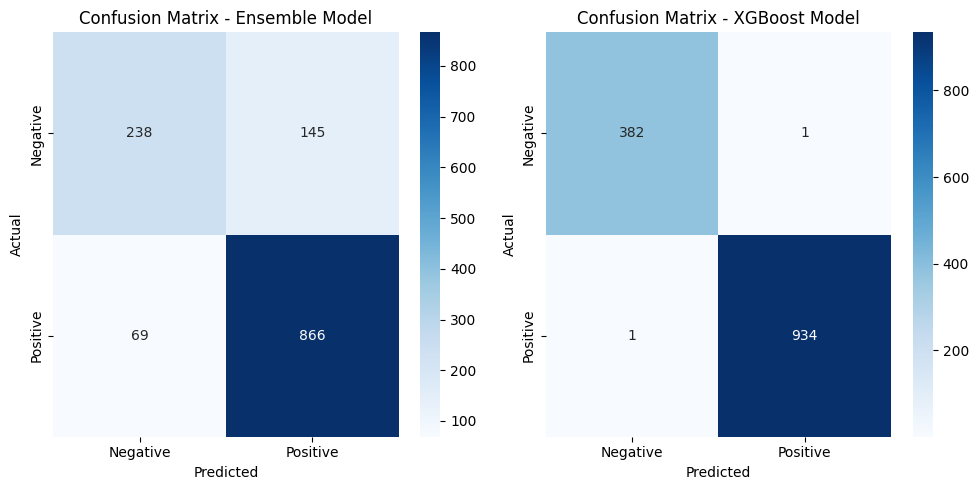

In [123]:
# Defining class labels
class_labels = ["Negative", "Positive"]

# Setting the figure size
plt.figure(figsize=(10, 5))

# Plotting Ensemble Model Confusion Matrix 
plt.subplot(1, 2, 1)
sns.heatmap(ensemble_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - Ensemble Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Plotting XGBoost Model Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(xgb_confusion_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title("Confusion Matrix - XGBoost Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

Calculating ROC Curve and AUC for XGBoost Model:

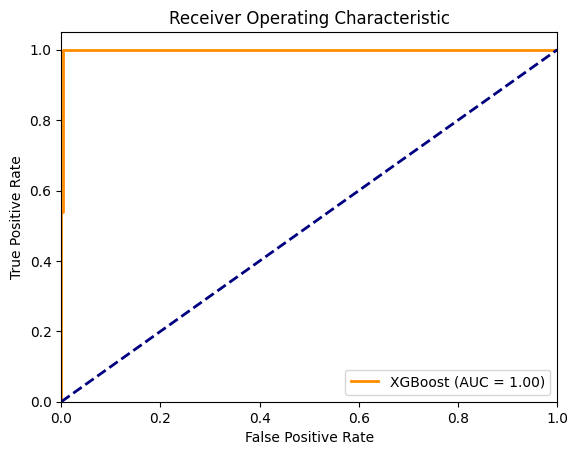

In [124]:
# Obtaining the predicted probabilities from the XGBoost model
xgb_probabilities = xgb_model.predict_proba(ensemble_predictions)[:, 1]

# Computing ROC curve and AUC for the XGBoost model
fpr_xgb, tpr_xgb, _ = roc_curve(y_test_encoded, xgb_probabilities)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

# Plotting the ROC curve for the XGBoost model
plt.figure()
plt.plot(fpr_xgb, tpr_xgb, color='darkorange', lw=2, label='XGBoost (AUC = %0.2f)' % roc_auc_xgb)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()